Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования


status: done

comp: work

выводы: без регуляризаторов sparse показатель плохой, kernel size очень большой (100), остальные kernel показатели похожи, по distances темы ближе, чем оригинальные, но всё равно далеко друг от друга.
По distances: с и без регуляризаторов показатели не сильно различаются, порог нахождения колонок высокий
По opt_res: лучше чем distances, показатели неплохие (при 0.35--0.4) находит все оригинальные колонки.


|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|     	|   5	|  20  	|
|   closest by dist original/test  	|     	|     	|   5 	|  20  	|
| closest by opt res test/original 	|     	|  h20 	|     	|     	|
| closest by opt res original/test 	|     	|   0  	|   0  	|  h16 	|

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_20_03_20\models.txt


In [3]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [4]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [5]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [6]:
models_count = 100
names_list, models_list = [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

# 20 topics
## decorrelator only
* без обучения сначала

name = model_rch_20_1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 1.5
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.91
|phi_ij == 0| / n_topics       2126.43  2019.55
|phi_ij > 0.2| / n_topics         0.23     0.10
|phi_ij > 0.1| / n_topics         0.89     0.60
|phi_ij > 0.01| / n_topics       27.16    22.10
|phi_ij > 0.05| / n_topics        2.63     2.30
|phi_ij > 0.001| / n_topics      80.26   138.95
topic_kernel_average_size        23.68    94.80
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.82

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_6 not optimized
Column topic_12 not optimized
Column topic_15 not optimized
Dist fn = <function hellinger_dist at 0x000000000BF09AC8>, Processed th = 1.0, original columns count = 20

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20        Column topic_37 not optimized
Dist fn = <function hellinger_dist at 0x000000000BF09AC8>, Processed th = 1.0, original columns count = 20     [(u'topic_0', u'topic_17', 0, 17, 0.40447432839632186), (u'topic_1', u'topic_16', 1, 16, 0.34683804775776272), (u'topic_2', u'topic_15', 2, 15, 0.3210332770916387), (u'topic_3', u'topic_14', 3, 14, 0.41385120053979357), (u'topic_4', u'topic_13', 4, 13, 0.42503167287549215), (u'topic_5', u'topic_12', 5, 12, 0.48147840750256615), (u'topic_6', u'topic_11', 6, 11, 0.39250210163558319), (u'topic_7', u'topic_10', 7, 10, 0.35649590794334979), (u'topic_8', u'topic_19', 8, 19, 0.43865854902627827), (u'topic_9', u'topic_18', 9, 18, 0.39361837428661817), (u'topic_10', u'topic_5', 10, 5, 0.499844361523544), (u'topic_11', u'topic_4', 11, 4, 0.43445568951509717), (u'topic_12', u'topic_3', 12, 3, 0.43105290403360585), (u'topic_13', u'topic_2', 13, 2, 0.410

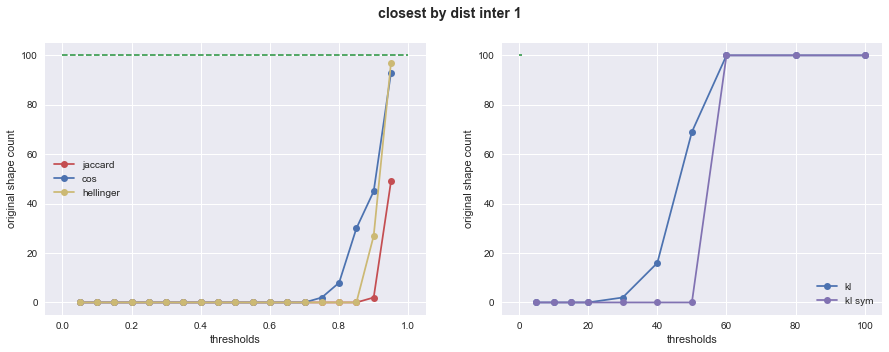

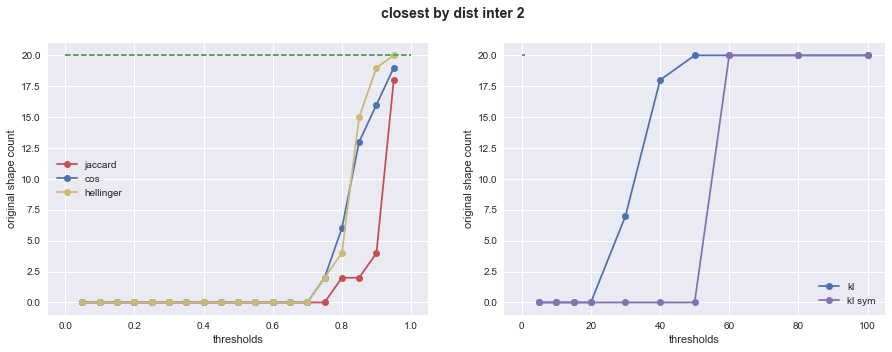

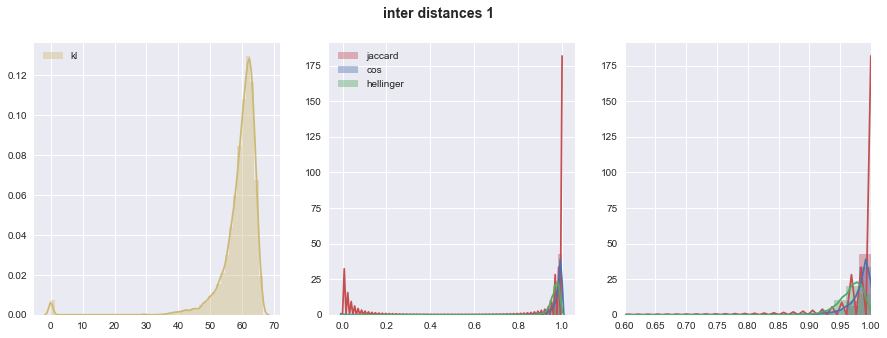

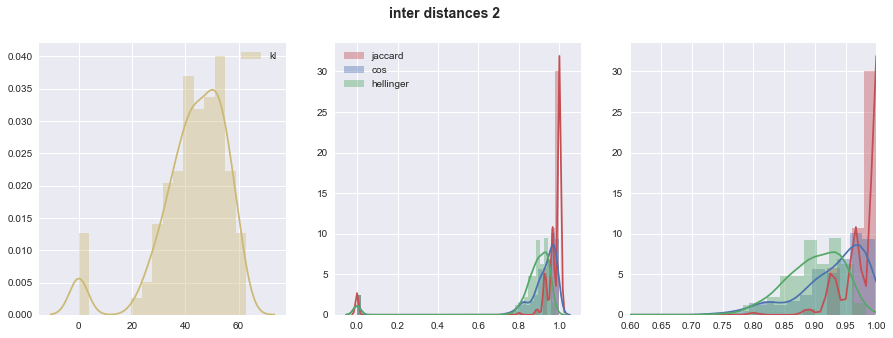

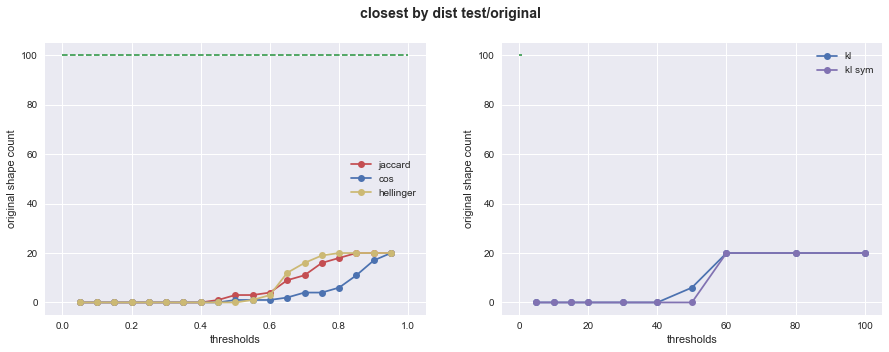

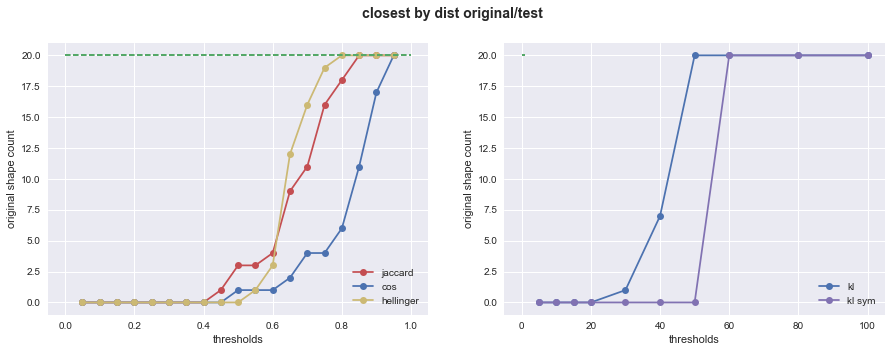

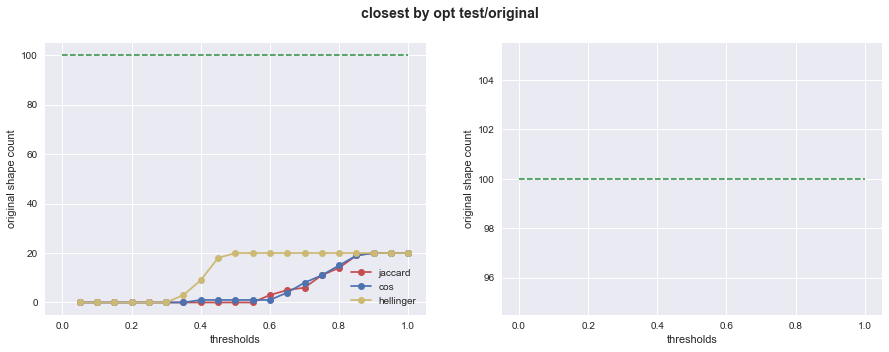

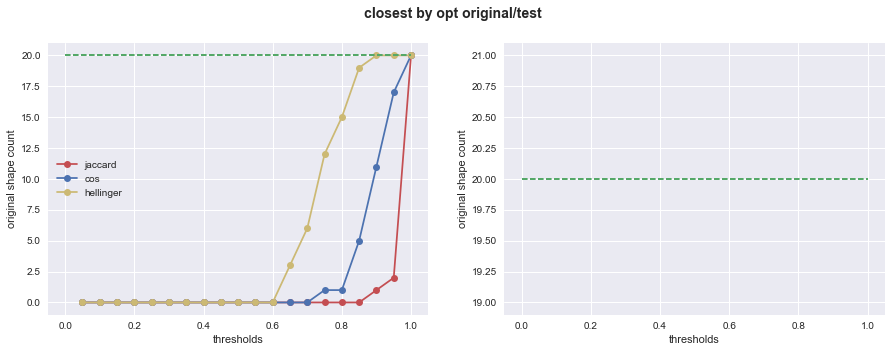

In [7]:
def create_model_rch_20_1(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
names_list[idx] = u'model_rch_20_1'
models_list[idx] = create_model_rch_20_1(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20 
* **kernel size**: 24 vs 94, **purity**: .63 vs .71, **contrast** .78 vs .82, **$phi_{ij}$**:  no 
* **closest by dist**: примерно так же различны, как и original
* **inter distances**: более размазанные

|                                  | 0.2 | 0.4 | 0.6 | 0.8 |
|:--------------------------------:|:---:|:---:|:---:|:---:|
|   closestby dist test/original   |     |  0  |  5  | j18-h20    |
|   closest by dist original/test  |     |  0  | < 5 | 20  |
| closest by opt res test/original |     |  8  | h20(0.45) |     |
| closest by opt res original/test |     |  0  |  0  |  h15 ||
* **Выводы**: opt значительно лучше, чем dist, понятно различие в порядке для opt (так как зависит не от одной колонки, а от л/к)
* **TODO**: 


побольше декоррелятор + fit model сначала

name = model_rch_20_2_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_20_2_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 3
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.90
|phi_ij == 0| / n_topics       2126.43  1983.95
|phi_ij > 0.2| / n_topics         0.23     0.05
|phi_ij > 0.1| / n_topics         0.89     0.55
|phi_ij > 0.01| / n_topics       27.16    21.45
|phi_ij > 0.05| / n_topics        2.63     1.95
|phi_ij > 0.001| / n_topics      80.26   147.75
topic_kernel_average_size        23.68   114.40
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_2 not optimized
Column topic_7 not optimized
Column topic_9 not optimized
Column topic_10 not optimized
Column topic_15 not optimized
Column topic_19 not optimized
Dist fn = <functio

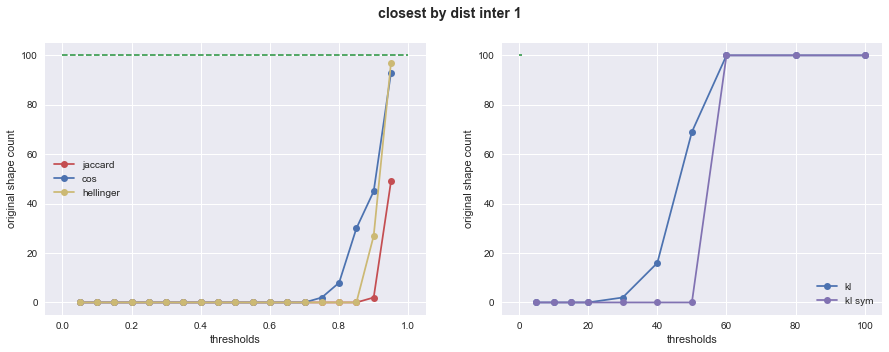

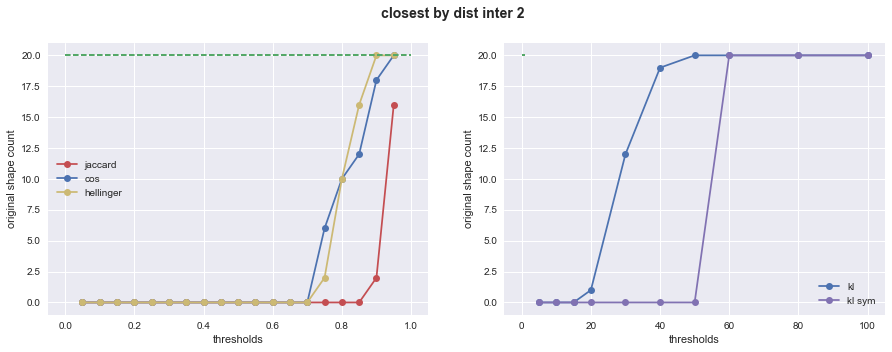

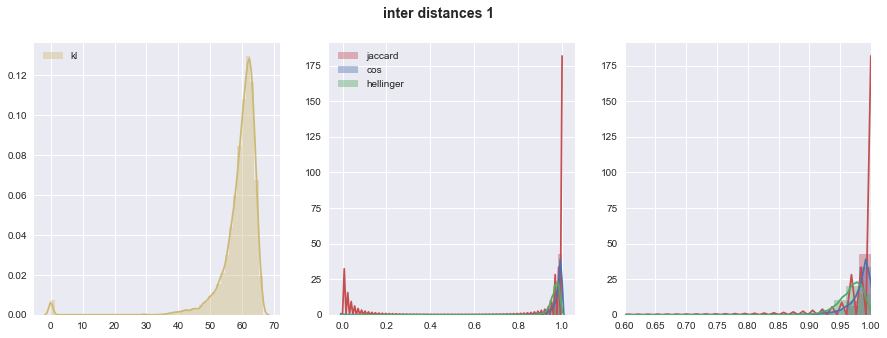

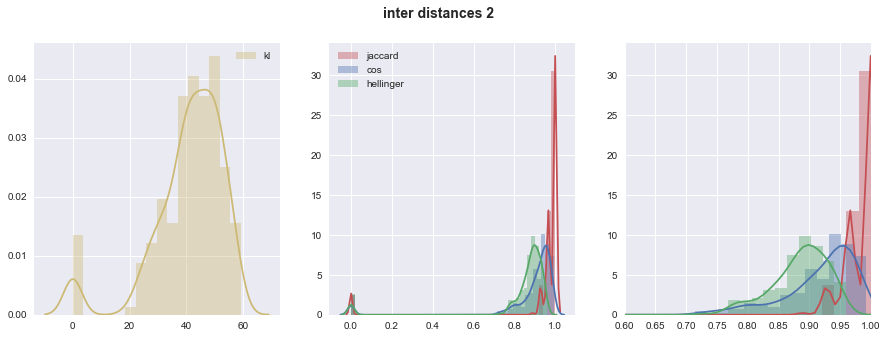

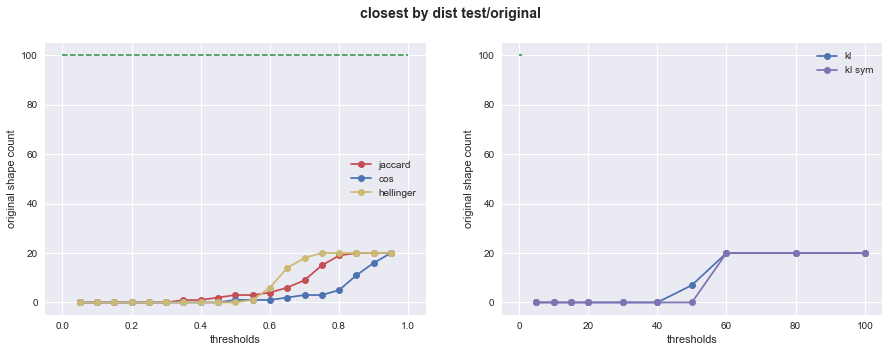

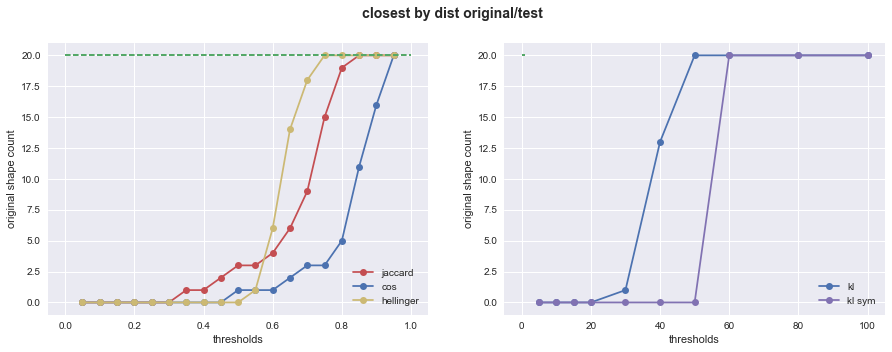

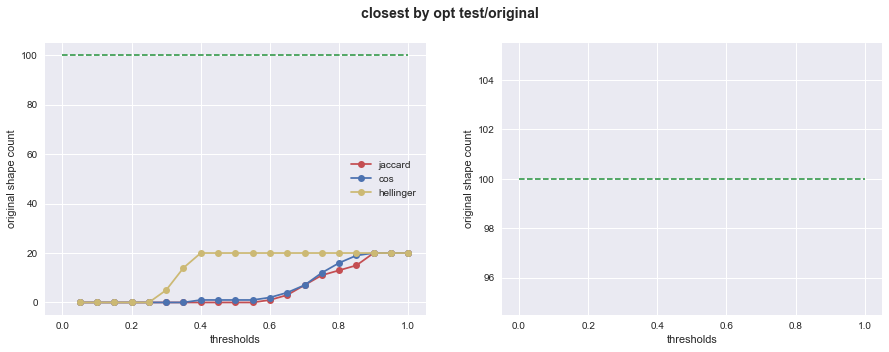

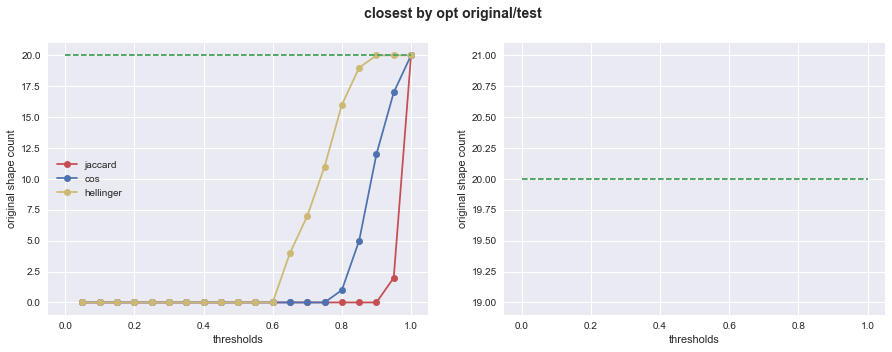

In [8]:
def create_model_rch_20_2(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 3
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
names_list[idx] = u'model_rch_20_2'
models_list[idx] = create_model_rch_20_2(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20
* **kernel size**: 24 vs 114, **purity**: .63 vs .68, **contrast** .78 vs .84, **$phi_{ij}$**:  no (более размазанные темы с меньшим числом сильных коэффициентов)
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|   0 	|  < 5  |  20  	|
|   closest by dist original/test  	|     	|     	|  h5  	|  20 	|
| closest by opt res test/original 	|     	|  h20 	|     	|     	|
| closest by opt res original/test 	|     	|     	|  0 	|  18 	||
* **Выводы**: не сильно отличается от предыдущей
* **TODO**: 

Sparse низкий. Попробуем ещё больше декоррелятор сделать. 

name = model_rch_20_3_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_20_3_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -3
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -3

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.90
|phi_ij == 0| / n_topics       2126.43  2000.25
|phi_ij > 0.2| / n_topics         0.23     0.05
|phi_ij > 0.1| / n_topics         0.89     0.55
|phi_ij > 0.01| / n_topics       27.16    22.00
|phi_ij > 0.05| / n_topics        2.63     1.75
|phi_ij > 0.001| / n_topics      80.26   146.85
topic_kernel_average_size        23.68   107.05
topic_kernel_average_purity       0.63     0.67
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000C0A84A8>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000C0A8518>
Processing <function cos_dist at 0x000000000C0A85F8>
Processing <function hellinger_dist at 0x000000000C0A8668>
Processing <function kl_dist at 0x000000000C017748>
Processing <function kl_sym_dist at 0x000000000C0A84A8>
Processing <function jaccard_dist at 0x000000000C0A8518>
Processing <function cos_dist at 0x000000000C0A85F8>
Processing <function hellinger_dist at 0x000000000C0A8668>
Processing <function kl_dist at 0x000000000C017748>
Processing <function kl_sym_dist at 0x000000000C0A84A8>
Dist fn = <function cos_dist at 0x000000000C0A85F8>, Processed th = 1.0, original columns count = 20           Column topic_2 not optimized
Column topic_5 not optimized
Column topic_6 not optimized
Column topic_7 not optimized
Column topic_9 not optimized
Column topic_12 not optimized
Column topic_14 not optimized
Dist fn = <function

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function hellinger_dist at 0x000000000C0A8668>, Processed th = 1.0, original columns count = 20     [(u'topic_0', u'topic_17', 0, 17, 0.33341089201786644), (u'topic_1', u'topic_16', 1, 16, 0.28584575686113856), (u'topic_2', u'topic_15', 2, 15, 0.28909589052625201), (u'topic_3', u'topic_14', 3, 14, 0.35967144311788185), (u'topic_4', u'topic_13', 4, 13, 0.36267196979786953), (u'topic_5', u'topic_12', 5, 12, 0.36140083414538243), (u'topic_6', u'topic_11', 6, 11, 0.33366033108154236), (u'topic_7', u'topic_10', 7, 10, 0.31753016723949568), (u'topic_8', u'topic_19', 8, 19, 0.38769027604895895), (u'topic_9', u'topic_18', 9, 18, 0.34503918632298897), (u'topic_10', u'topic_5', 10, 5, 0.30954474937614523), (u'topic_11', u'topic_4', 11, 4, 0.38671343367615929), (u'topic_12', u'topic_3', 12, 3, 0.38698391737711563), (u'topic_13', u'topic_2', 13, 2, 0.41411676049709917), (u'topic_14', u'topic_9', 14, 9, 0.36081447917925097), (u'topic_15', u'topic_8', 15, 8, 0.36754842338178506), (u'topic

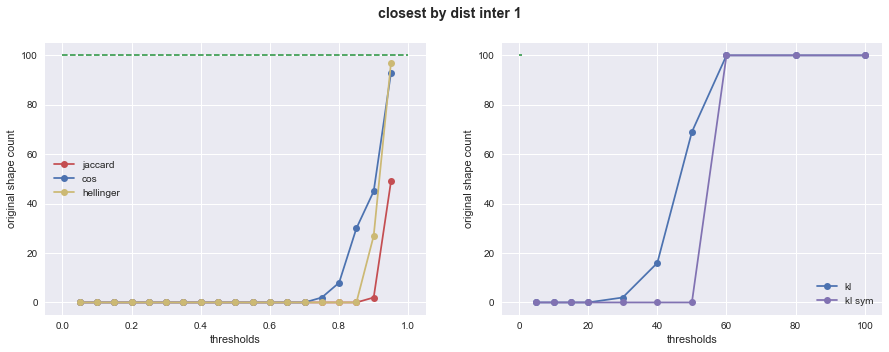

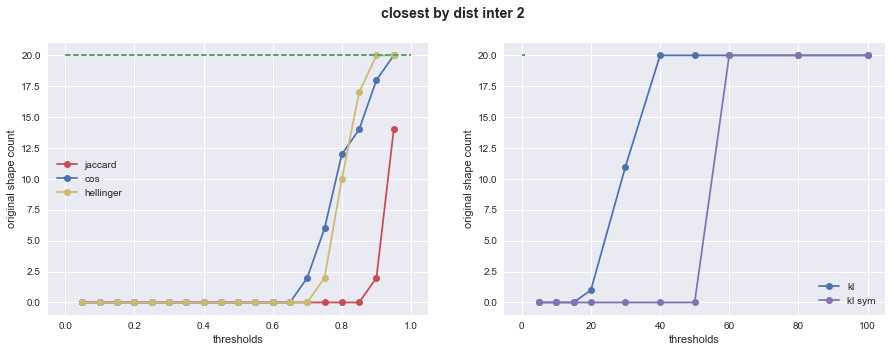

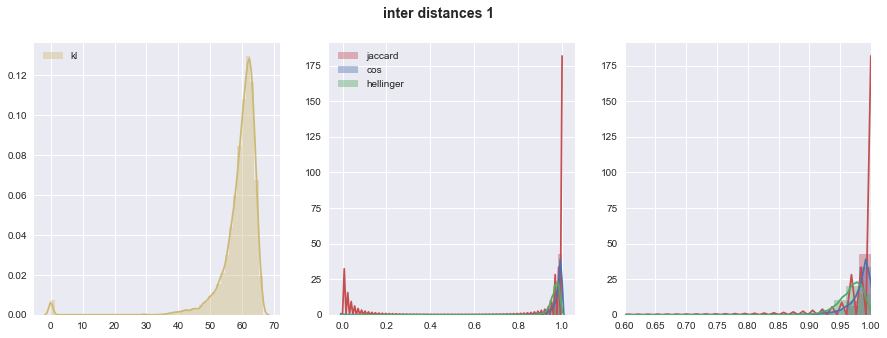

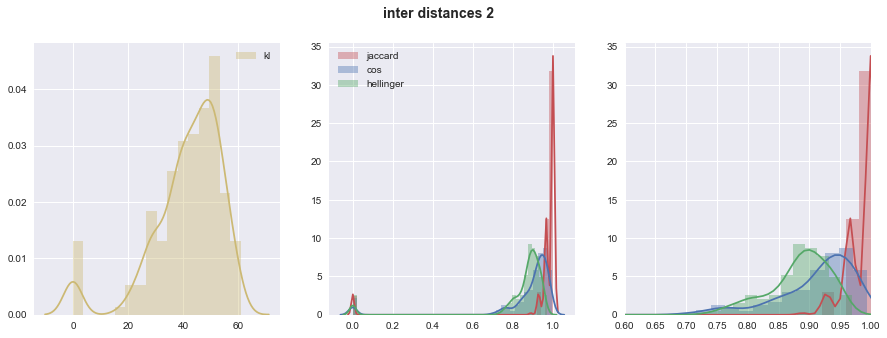

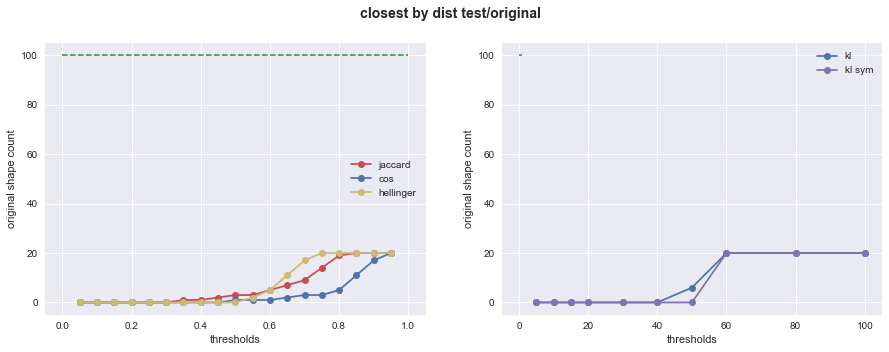

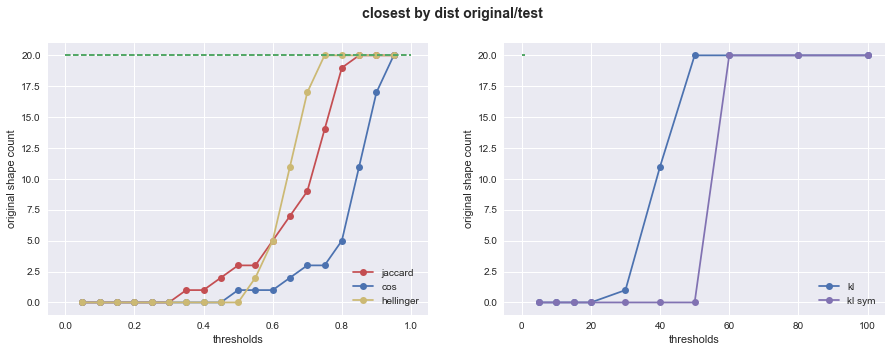

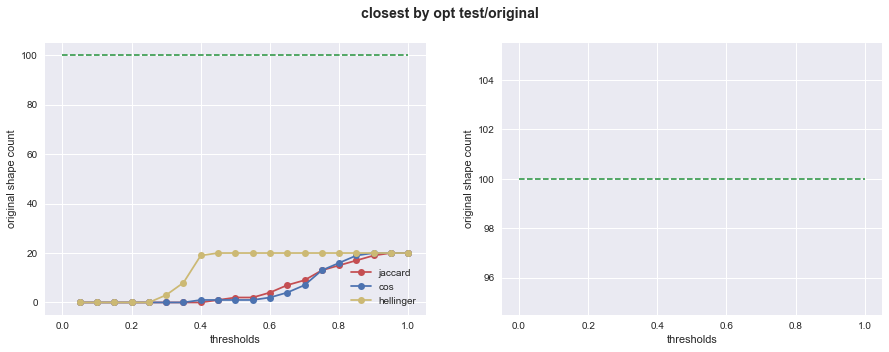

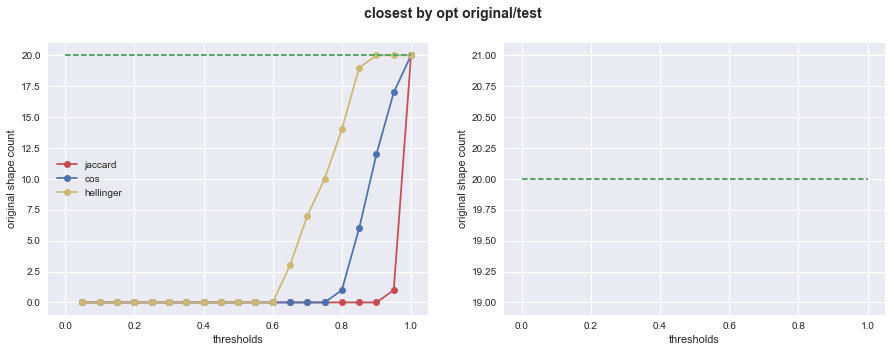

In [7]:
def create_model_rch_20_3(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -3
    tmp_model.regularizers['ss_phi_regularizer'].tau = -3
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
names_list[idx] = u'model_rch_20_3'
models_list[idx] = create_model_rch_20_3(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20, 0.90
* **kernel size**: 24 vs 114, **purity**: .63 vs .67, **contrast** .78 vs .84, **$phi_{ij}$**:  -+++-
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|     	|   5	|  20  	|
|   closest by dist original/test  	|     	|     	|   5 	|  20  	|
| closest by opt res test/original 	|     	|  h20 	|     	|     	|
| closest by opt res original/test 	|     	|   0  	|   0  	|  h16 	||
* **Выводы**: тоже не очень отличается от предыдущей
* **TODO**: 

Попробуем убрать обучение сначала.

name = model_rch_20_4_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило: 

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.91
|phi_ij == 0| / n_topics       2126.43  2019.55
|phi_ij > 0.2| / n_topics         0.23     0.10
|phi_ij > 0.1| / n_topics         0.89     0.60
|phi_ij > 0.01| / n_topics       27.16    22.10
|phi_ij > 0.05| / n_topics        2.63     2.30
|phi_ij > 0.001| / n_topics      80.26   138.95
topic_kernel_average_size        23.68    94.80
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.82

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_4 not optimized
Column topic_7 not optimized
Column topic_9 not optimized
Column topic_12 not optimized
Column topic_13 not optimized
Column topic_15 not optimized
Column topic_18 no

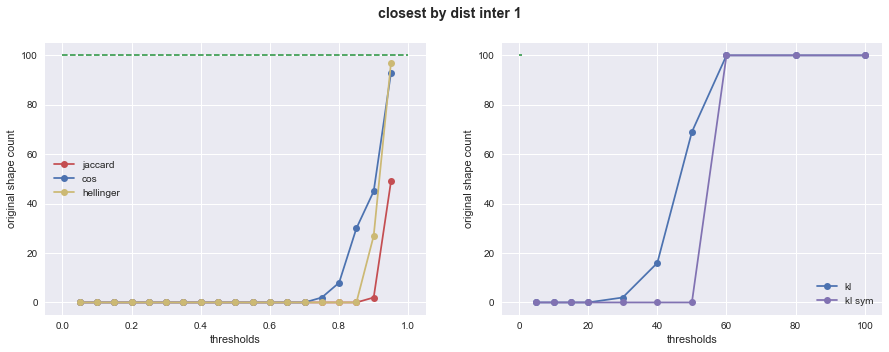

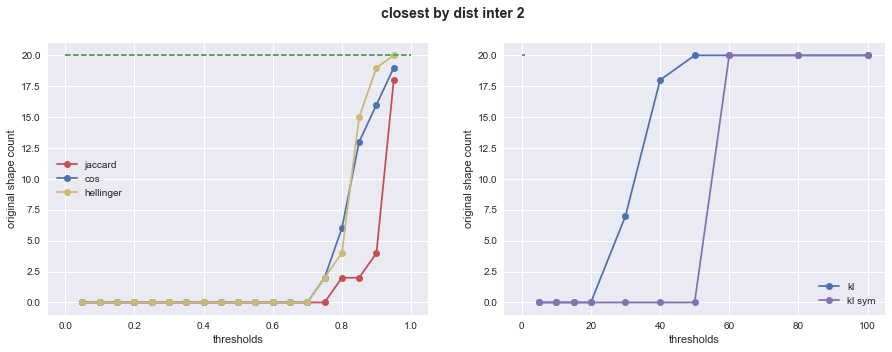

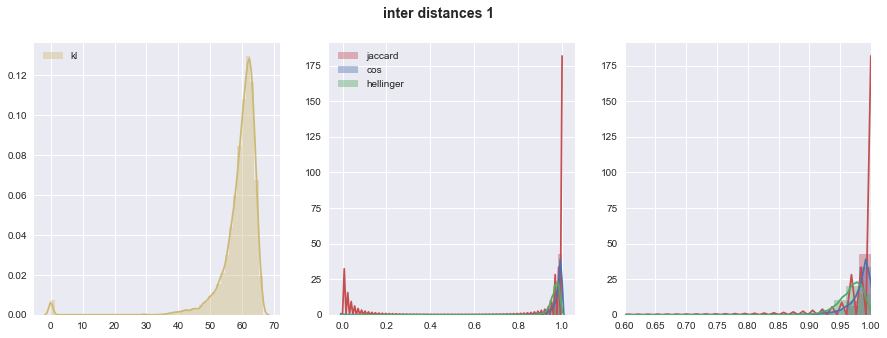

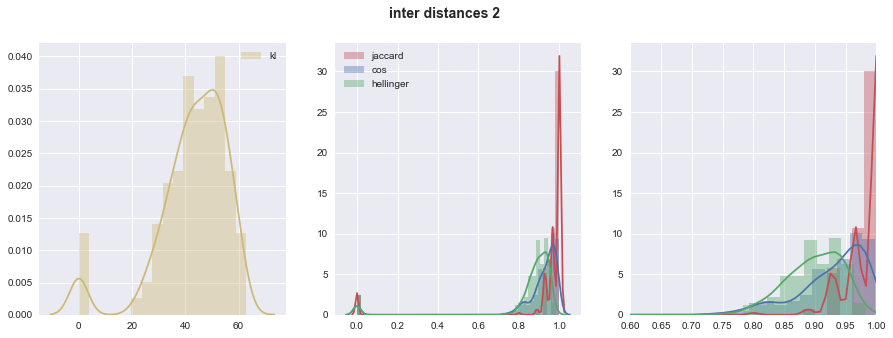

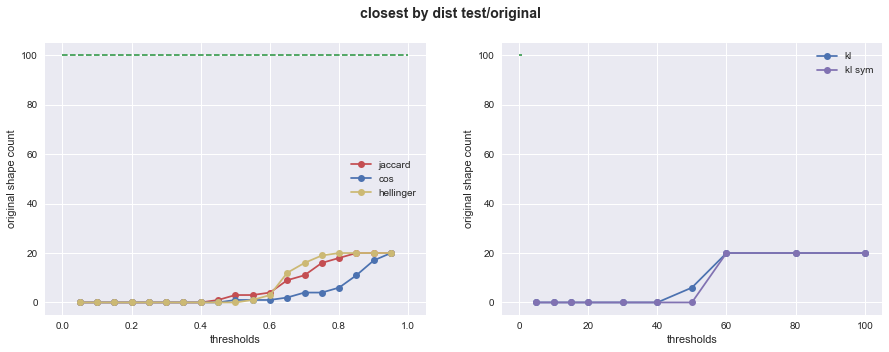

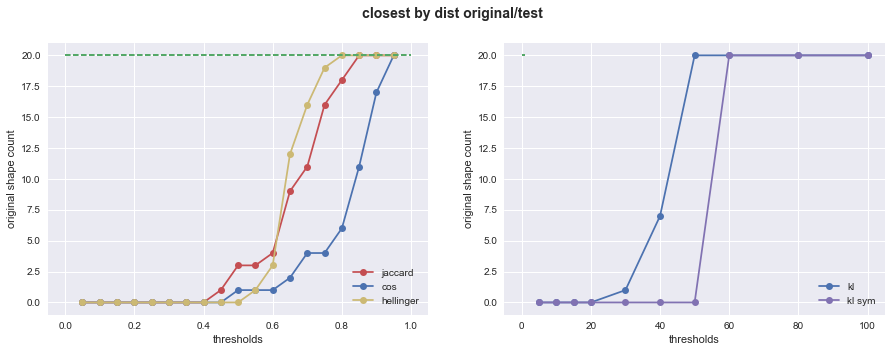

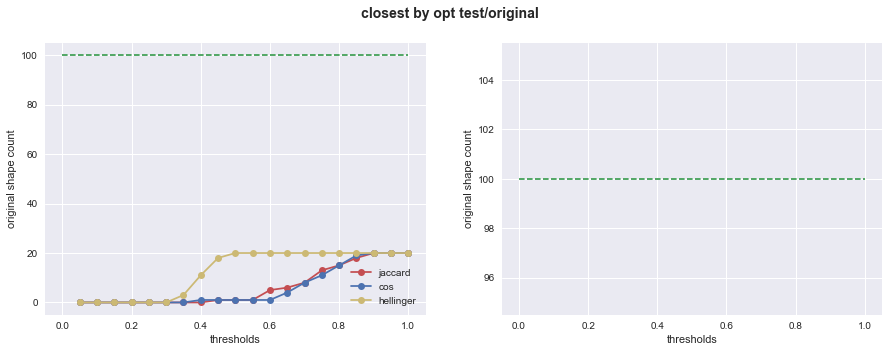

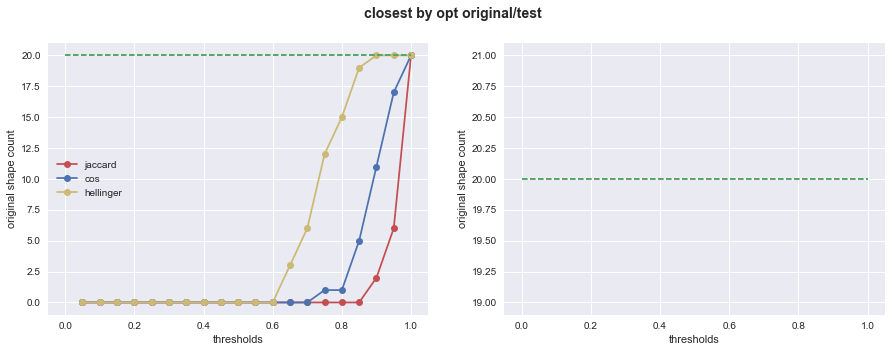

In [10]:
def create_model_rch_20_4(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
names_list[idx] = u'model_rch_20_4'
models_list[idx] = create_model_rch_20_4(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20
* **kernel size**: 24 vs 94, **purity**: .63 vs .71, **contrast** .78 vs .82, **$phi_{ij}$**:  5
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|   0  	|  < 5 	|  20  	|
|   closest by dist original/test  	|     	|   -  	|   -  	|   -  	|
| closest by opt res test/original 	|     	|   15 	|  h20(0.45) 	|     	|
| closest by opt res original/test 	|     	|     	|   0  	|  h15 	||
* **Выводы**: убрали обучение вначале -> kernel size немного ниже, dist такой же, opt порог выше
* **TODO**: 

## topic selection only
Без обучения в начале, коэф маленький (0.1)

name = model_rch_20_1_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.1

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.91
|phi_ij == 0| / n_topics       2126.43  2013.70
|phi_ij > 0.2| / n_topics         0.23     0.10
|phi_ij > 0.1| / n_topics         0.89     0.55
|phi_ij > 0.01| / n_topics       27.16    21.85
|phi_ij > 0.05| / n_topics        2.63     2.00
|phi_ij > 0.001| / n_topics      80.26   140.70
topic_kernel_average_size        23.68    95.10
topic_kernel_average_purity       0.63     0.70
topic_kernel_average_contrast     0.78     0.81

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_2 not optimized
Column topic_3 not optimized
Column topic_4 not optimized
Column topic_12 not optimized
Column topic_13 not optimized
Column topic_15 not optimized
Column topic_18 not optimized
Dist fn = <functi

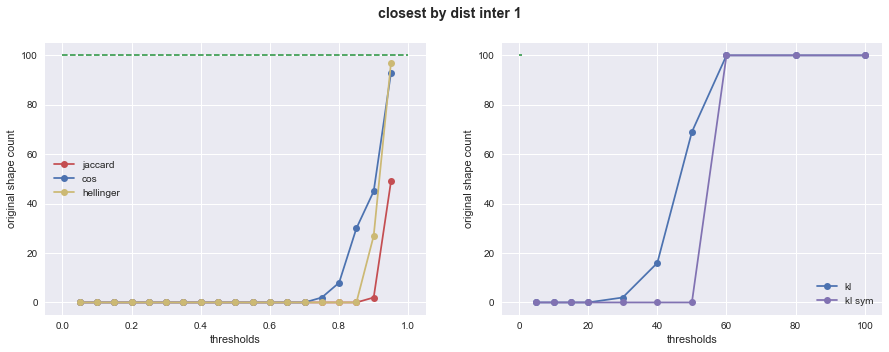

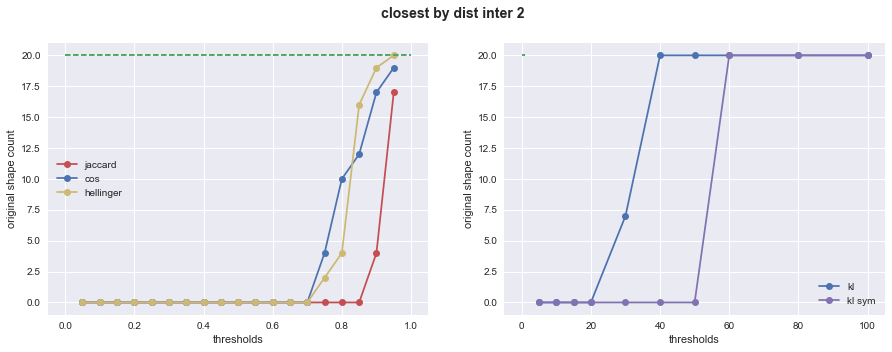

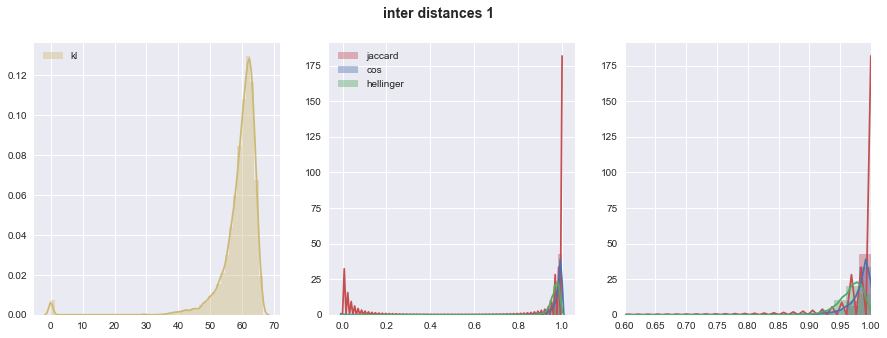

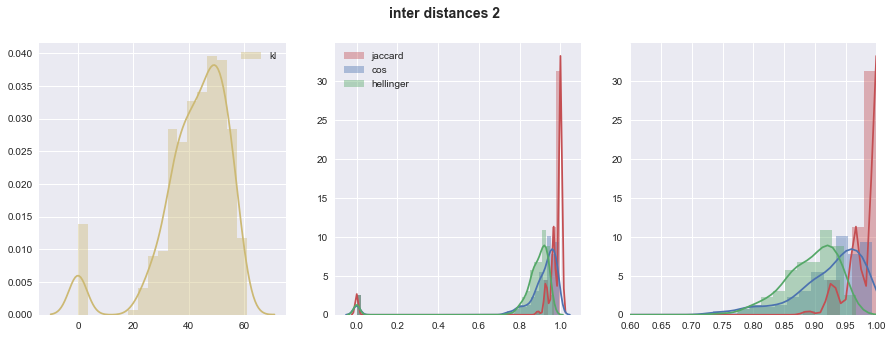

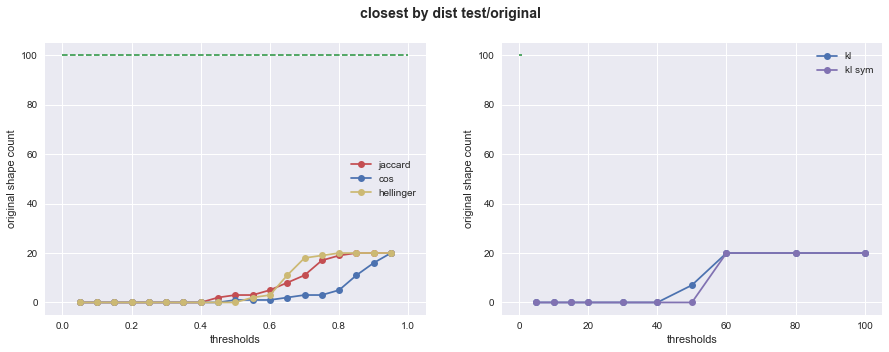

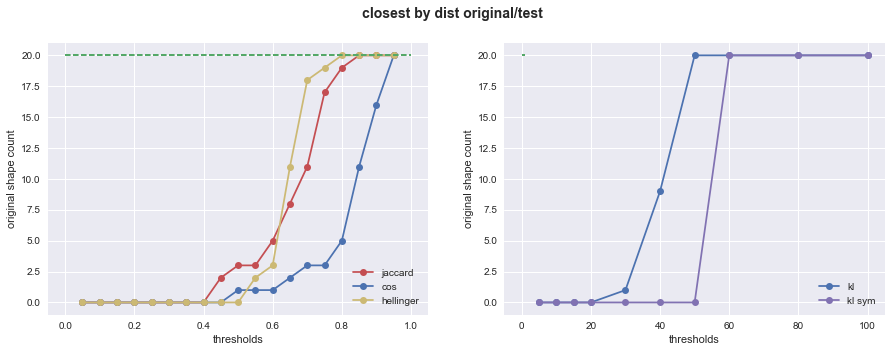

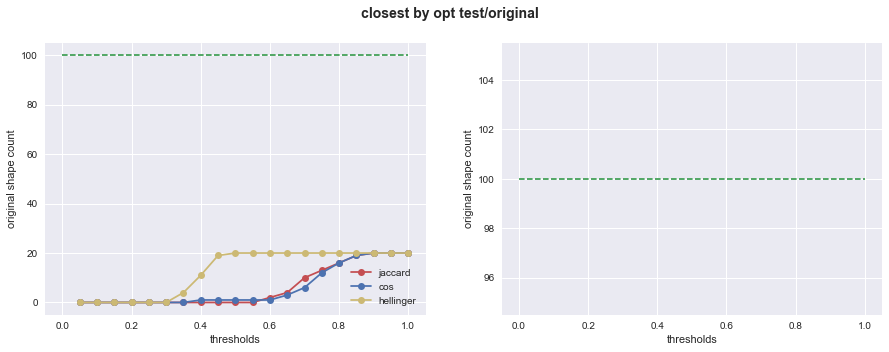

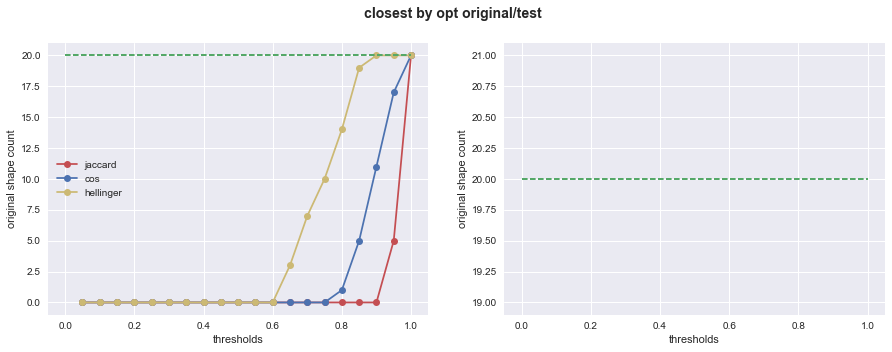

In [11]:
def create_model_rch_20_1_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.1
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
names_list[idx] = u'model_rch_20_1_ts'
models_list[idx] = create_model_rch_20_1_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20
* **kernel size**: 24 vs 95, **purity**: .63 vs .70, **contrast** .78 vs .81, **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|   0  	|   5  	|  20  	|
|   closest by dist original/test  	|     	|   - 	|   -  	|  -   	|
| closest by opt res test/original 	|     	|   0 	|  h20 	|     	|
| closest by opt res original/test 	|     	|     	|   0  	|  14  	||
* **Выводы**: немного хуже, чем декор, а так примерно одинаковый, спарсе низкий
* **TODO**: 

Увеличим коэф (с 0 0.1 до 0.5) + начальное обучение без регуляризаторов.

name = model_rch_20_2_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_20_2_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.88
|phi_ij == 0| / n_topics       2126.43  1951.90
|phi_ij > 0.2| / n_topics         0.23     0.05
|phi_ij > 0.1| / n_topics         0.89     0.45
|phi_ij > 0.01| / n_topics       27.16    20.85
|phi_ij > 0.05| / n_topics        2.63     1.55
|phi_ij > 0.001| / n_topics      80.26   159.15
topic_kernel_average_size        23.68   114.60
topic_kernel_average_purity       0.63     0.64
topic_kernel_average_contrast     0.78     0.83

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_4 not optimized
Column topic_6 not optimized
Column topic_7 not optimized
Column topic_11 not optimized
Column topic_12 not optimized
Column topic_14 not optimized
Column topic_16 no

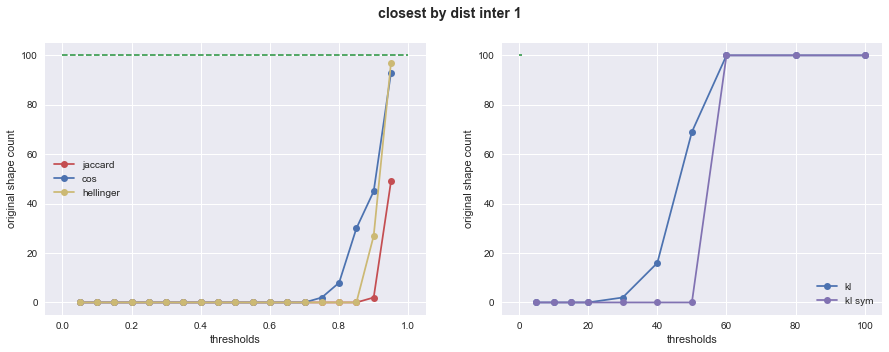

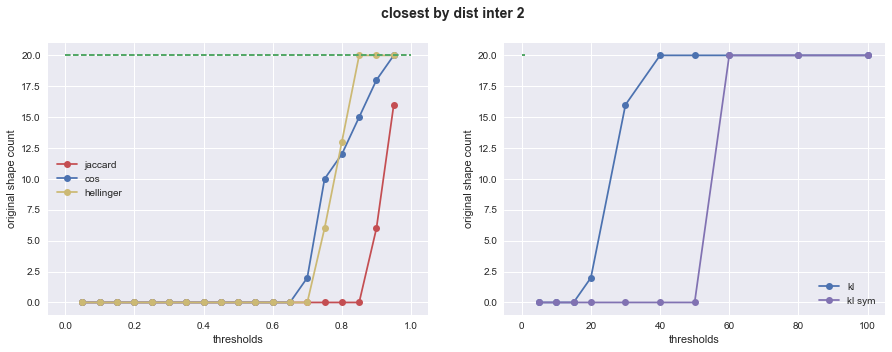

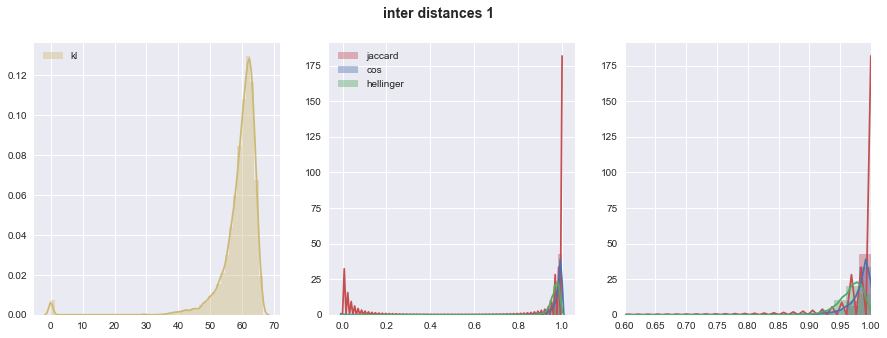

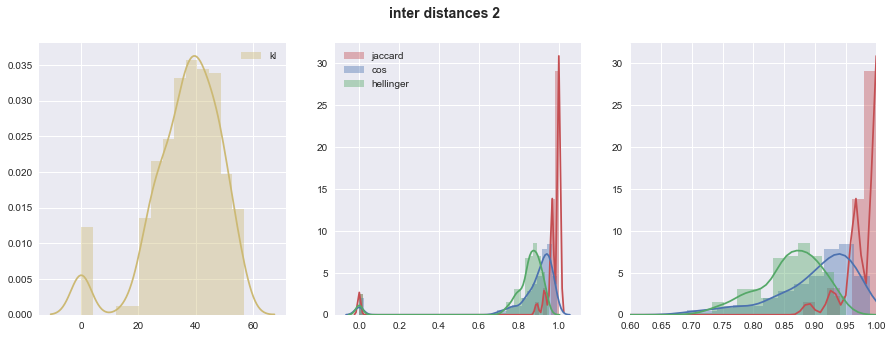

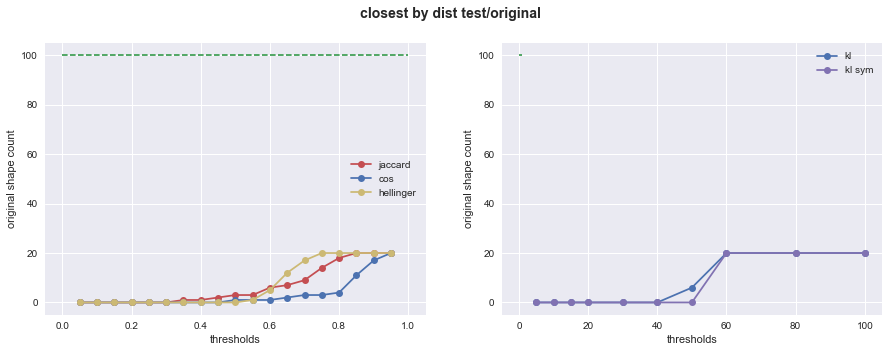

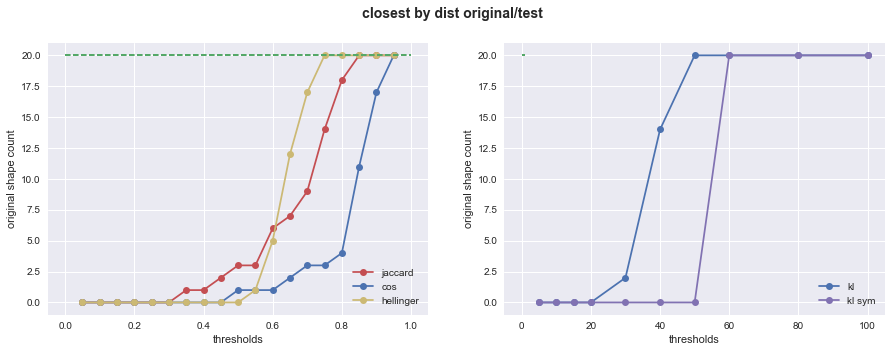

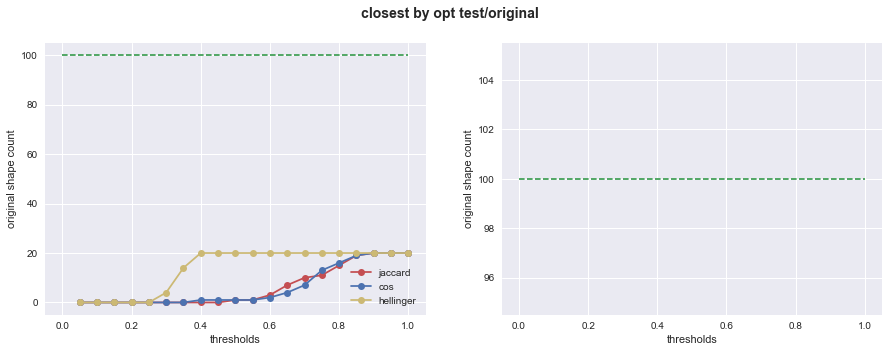

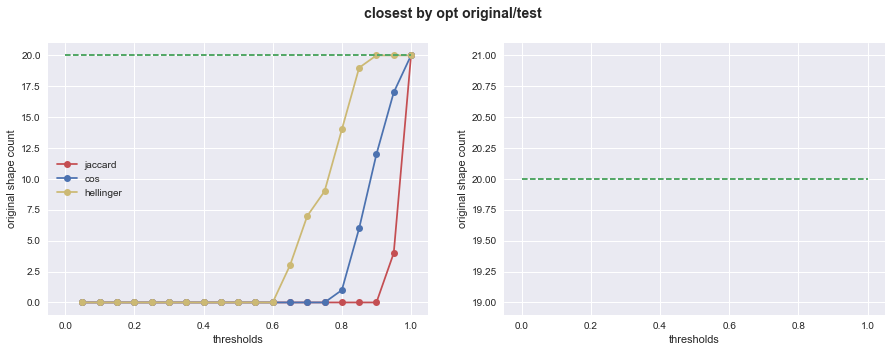

In [12]:
def create_model_rch_20_2_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
names_list[idx] = u'model_rch_20_2_ts'
models_list[idx] = create_model_rch_20_2_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  3
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|   0  	|   5  	|  20  	|
|   closest by dist original/test  	|     	|   -  	|   -  	|  -   	|
| closest by opt res test/original 	|     	|  h20 	|     	|     	|
| closest by opt res original/test 	|     	|     	|   0  	|   14 	||
* **Выводы**: не сильно отличается от пред.
* **TODO**: 

Увеличить спарсе коэффициенты (от -1.5 до -4)

name = model_rch_20_3_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_20_3_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -4
ss_phi_regularizer, tau = -4
topic_selection_theta_regularizer, tau = 0.6

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.89
|phi_ij == 0| / n_topics       2126.43  1967.15
|phi_ij > 0.2| / n_topics         0.23     0.00
|phi_ij > 0.1| / n_topics         0.89     0.40
|phi_ij > 0.01| / n_topics       27.16    21.40
|phi_ij > 0.05| / n_topics        2.63     1.30
|phi_ij > 0.001| / n_topics      80.26   163.85
topic_kernel_average_size        23.68   103.70
topic_kernel_average_purity       0.63     0.60
topic_kernel_average_contrast     0.78     0.81

Dist fn = <function kl_sym_dist at 0x000000000C0A84A8>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000C0A8518>
Processing <function cos_dist at 0x000000000C0A85F8>
Processing <function hellinger_dist at 0x000000000C0A8668>
Processing <function kl_dist at 0x000000000C017748>
Processing <function kl_sym_dist at 0x000000000C0A84A8>
Processing <function jaccard_dist at 0x000000000C0A8518>
Processing <function cos_dist at 0x000000000C0A85F8>
Processing <function hellinger_dist at 0x000000000C0A8668>
Processing <function kl_dist at 0x000000000C017748>
Processing <function kl_sym_dist at 0x000000000C0A84A8>
Dist fn = <function cos_dist at 0x000000000C0A85F8>, Processed th = 1.0, original columns count = 20           Column topic_6 not optimized
Column topic_7 not optimized
Column topic_10 not optimized
Column topic_12 not optimized
Column topic_14 not optimized
Column topic_15 not optimized
Column topic_16 not optimized
Dist fn = <funct

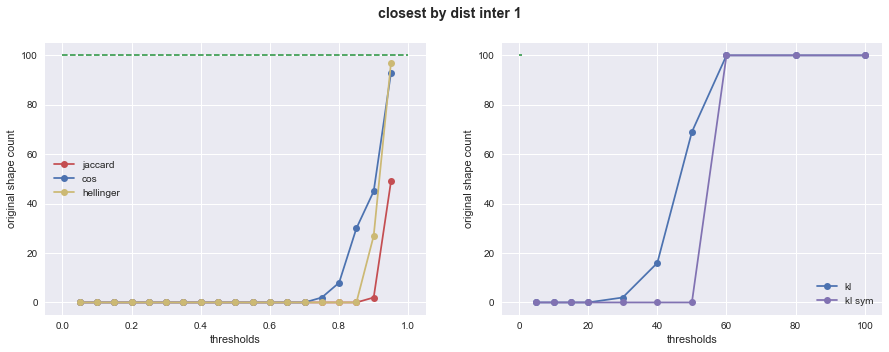

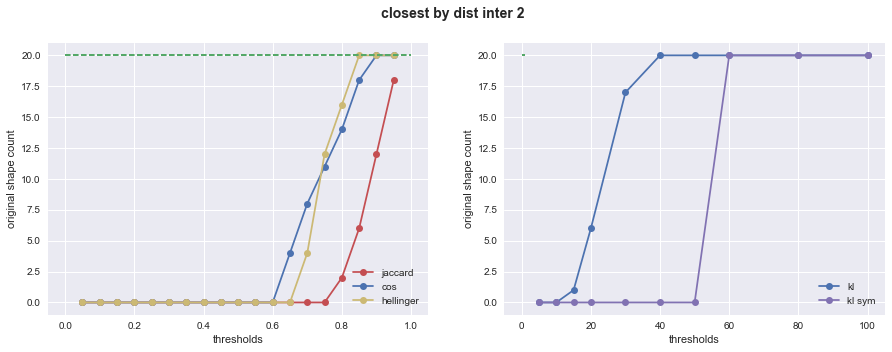

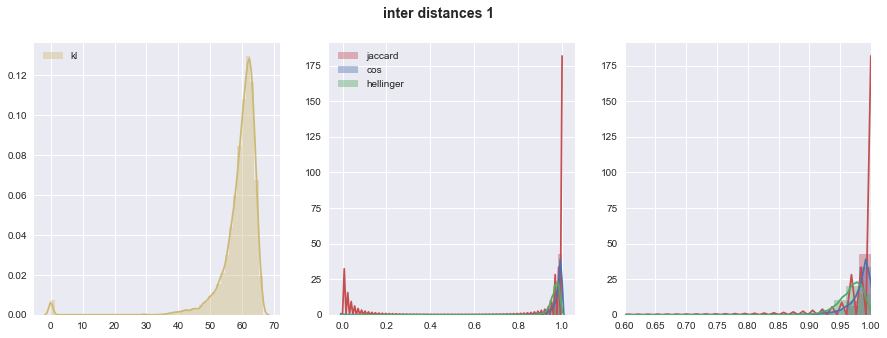

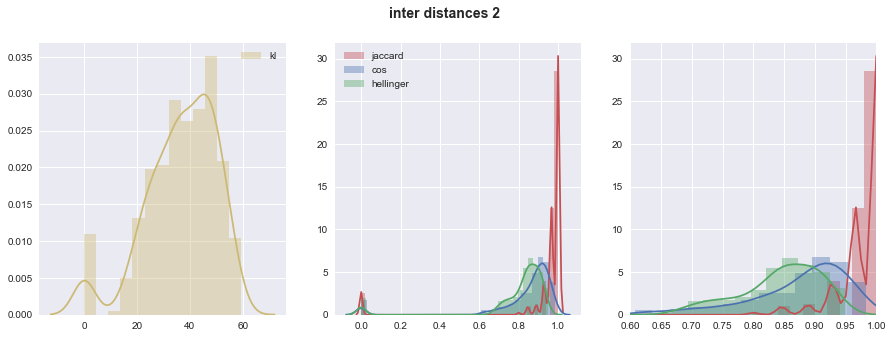

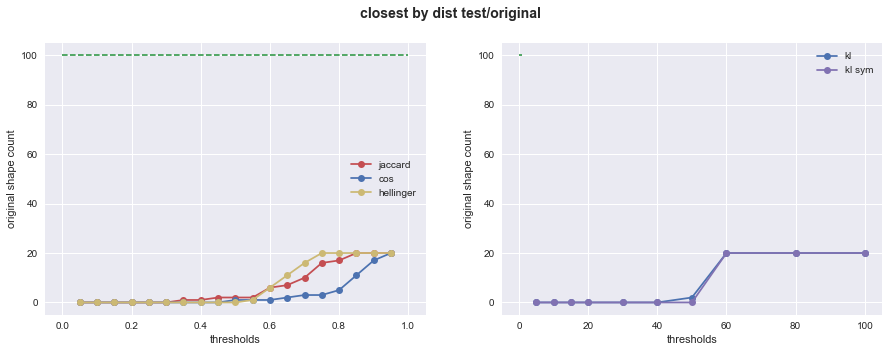

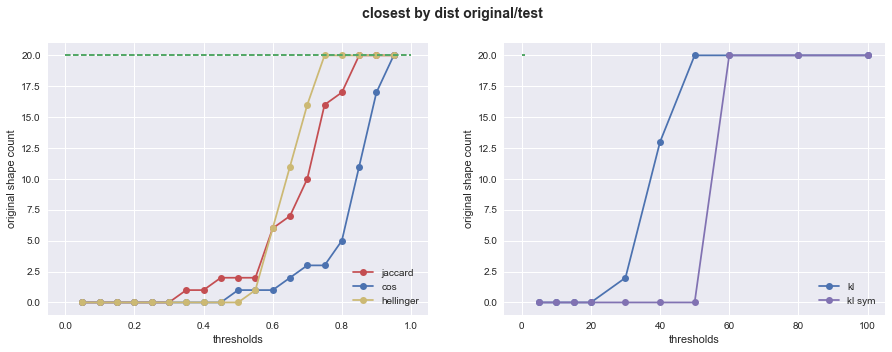

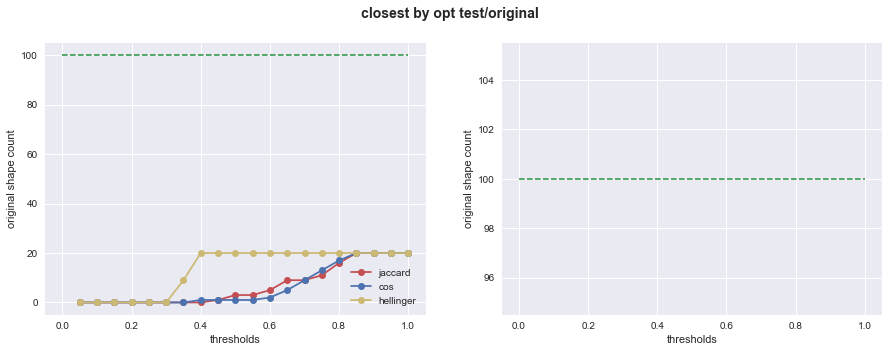

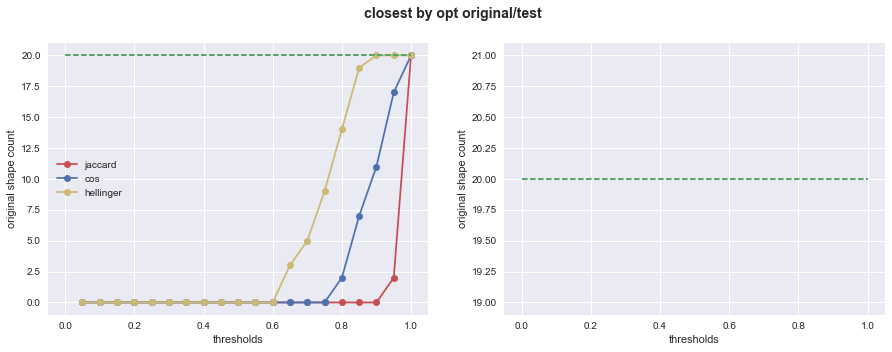

In [8]:
def create_model_rch_20_3_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -4
    tmp_model.regularizers['ss_phi_regularizer'].tau = -4
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 33
names_list[idx] = u'model_rch_20_3_ts'
models_list[idx] = create_model_rch_20_3_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|     	|     	|     	|
|   closest by dist original/test  	|     	|     	|     	|     	|
| closest by opt res test/original 	|     	|     	|     	|     	|
| closest by opt res original/test 	|     	|     	|     	|     	||
* **Выводы**: 
* **TODO**: 

Увеличим коэффициент отбора тем от 0.5 до 0.7

name = model_rch_20_4_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_20_4_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -4
ss_phi_regularizer, tau = -4
topic_selection_theta_regularizer, tau = 0.8

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.87
|phi_ij == 0| / n_topics       2126.43  1934.45
|phi_ij > 0.2| / n_topics         0.23     0.00
|phi_ij > 0.1| / n_topics         0.89     0.30
|phi_ij > 0.01| / n_topics       27.16    20.80
|phi_ij > 0.05| / n_topics        2.63     0.90
|phi_ij > 0.001| / n_topics      80.26   177.20
topic_kernel_average_size        23.68   102.80
topic_kernel_average_purity       0.63     0.53
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000C0A84A8>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000C0A8518>
Processing <function cos_dist at 0x000000000C0A85F8>
Processing <function hellinger_dist at 0x000000000C0A8668>
Processing <function kl_dist at 0x000000000C017748>
Processing <function kl_sym_dist at 0x000000000C0A84A8>
Processing <function jaccard_dist at 0x000000000C0A8518>
Processing <function cos_dist at 0x000000000C0A85F8>
Processing <function hellinger_dist at 0x000000000C0A8668>
Processing <function kl_dist at 0x000000000C017748>
Processing <function kl_sym_dist at 0x000000000C0A84A8>
Dist fn = <function cos_dist at 0x000000000C0A85F8>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_1 not optimized
Column topic_2 not optimized
Column topic_9 not optimized
Column topic_16 not optimized
Dist fn = <function cos_dist at 0x000000000C0A85F8>, Processed th = 1.0, origi

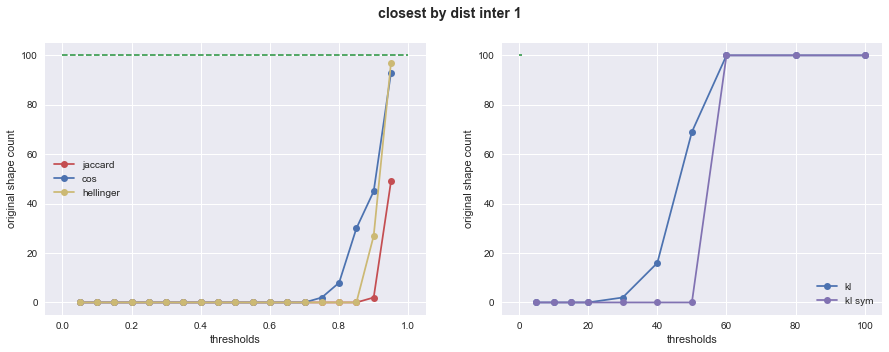

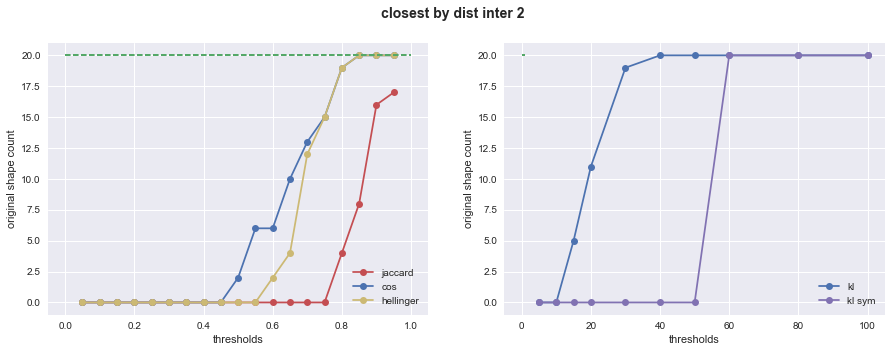

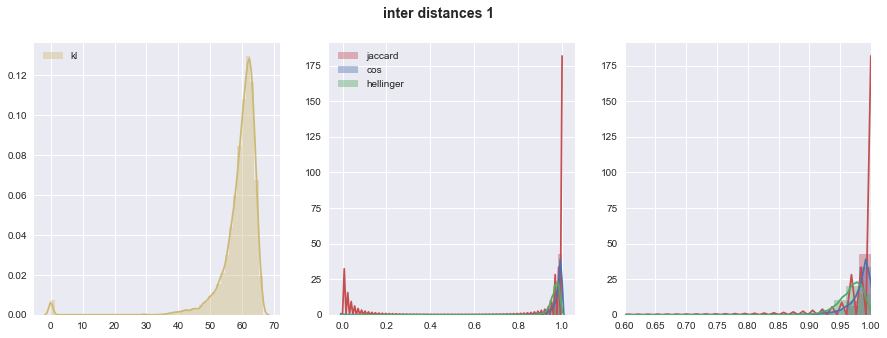

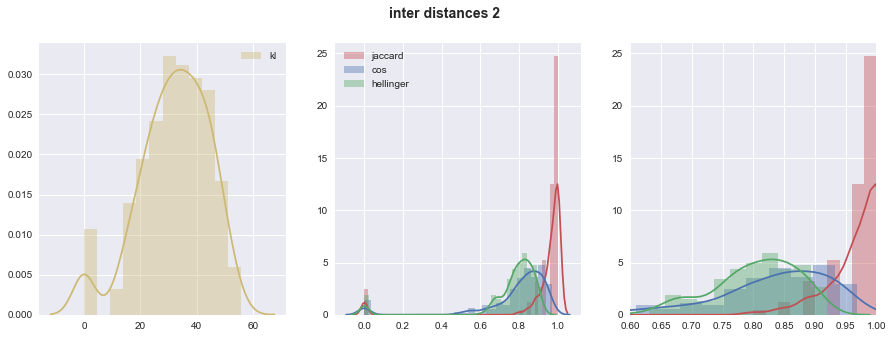

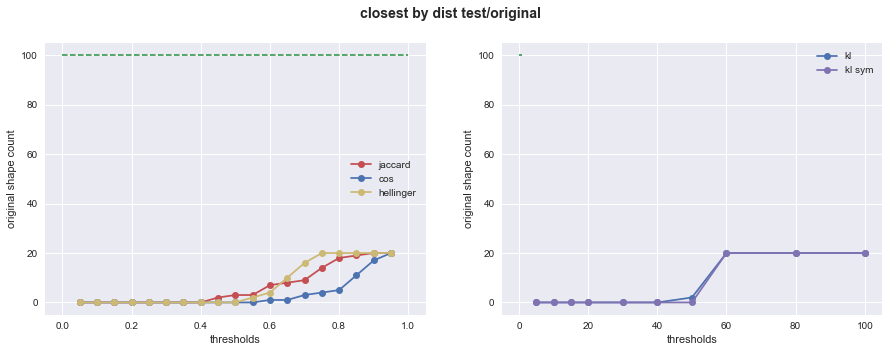

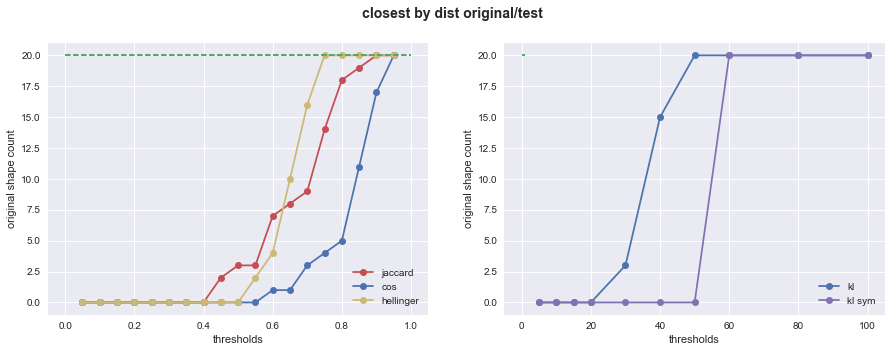

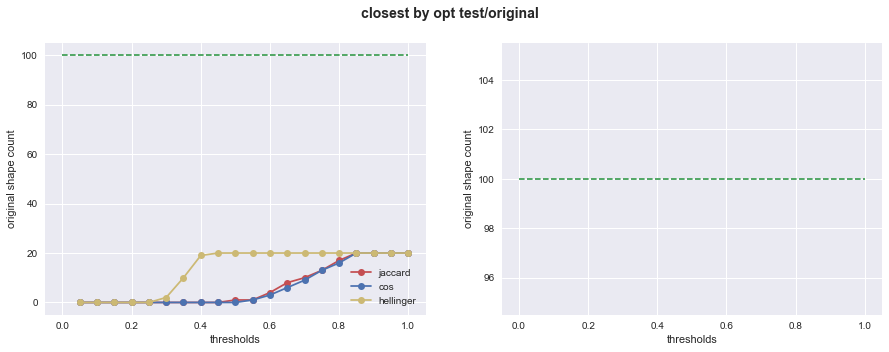

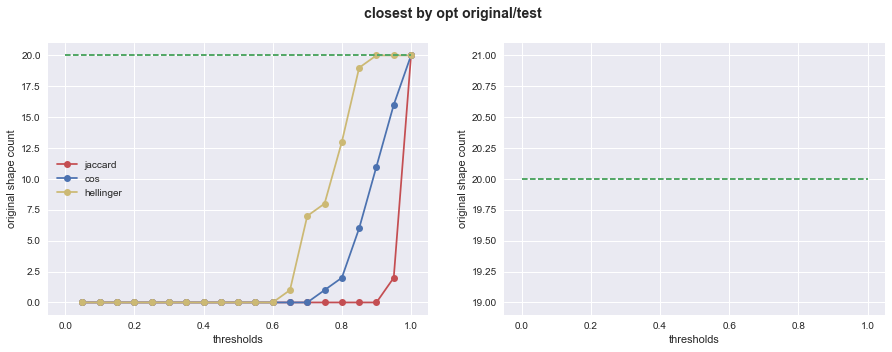

In [9]:
def create_model_rch_20_4_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.8
    tmp_model.regularizers['ss_theta_regularizer'].tau = -4
    tmp_model.regularizers['ss_phi_regularizer'].tau = -4
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 34
names_list[idx] = u'model_rch_20_4_ts'
models_list[idx] = create_model_rch_20_4_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 
* **closest by dist test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by dist original/test**:  0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res test/original**: 0.2: ; 0.4: ; 0.6: ; 0.8: 
* **closest by opt res original/test**: 0.2: ; 0.4: ; 0.6: ; 0.8: 

* **Выводы**: 
* **TODO**: 

Без регуляризаторов

name = model_rch_20_5_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило: 0.019 грамматика: 0.017 тип: 0.016 смысл: 0.014 существительное: 0.014
topic_2 | молекула: 0.150 бе

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.66
|phi_ij == 0| / n_topics       2126.43  1467.70
|phi_ij > 0.2| / n_topics         0.23     0.10
|phi_ij > 0.1| / n_topics         0.89     0.65
|phi_ij > 0.01| / n_topics       27.16    20.50
|phi_ij > 0.05| / n_topics        2.63     2.25
|phi_ij > 0.001| / n_topics      80.26   138.40
topic_kernel_average_size        23.68   123.55
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_3 not optimized
Column topic_7 not optimized
Dist fn = <function hellinger_dist at 0x000000000BF09AC8>, Processed th = 1.0, original columns count = 20     [(u'topic_0', u'topic_17',

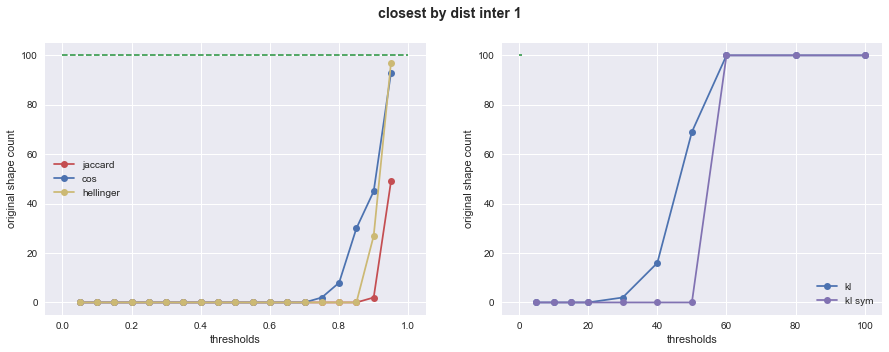

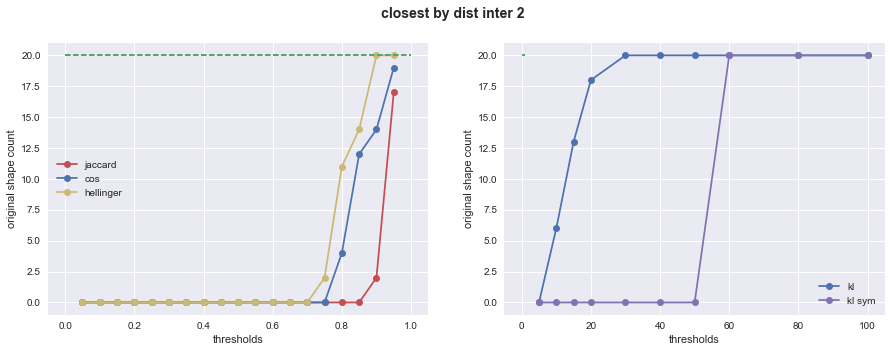

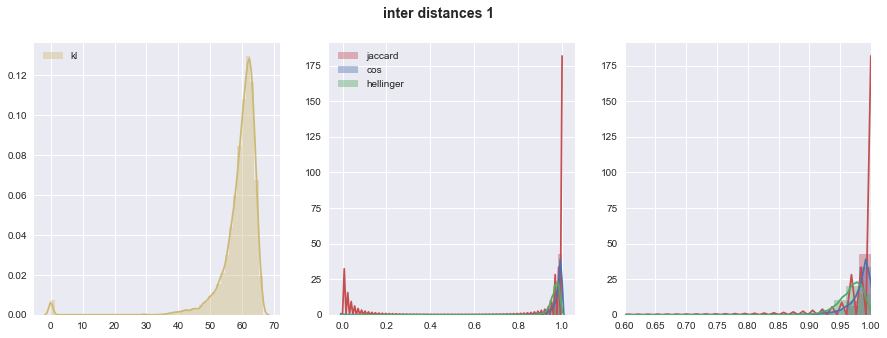

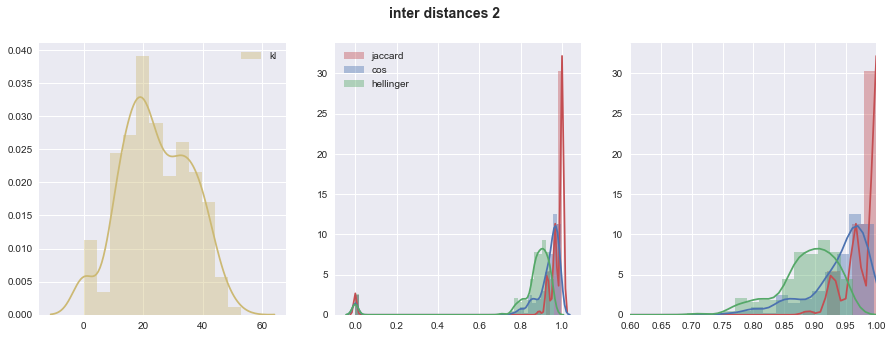

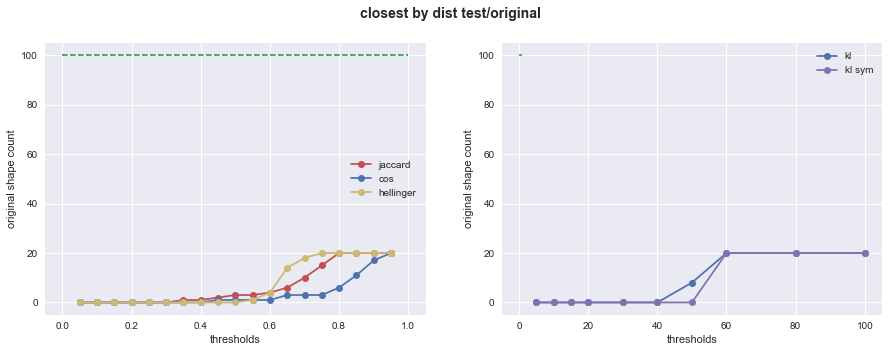

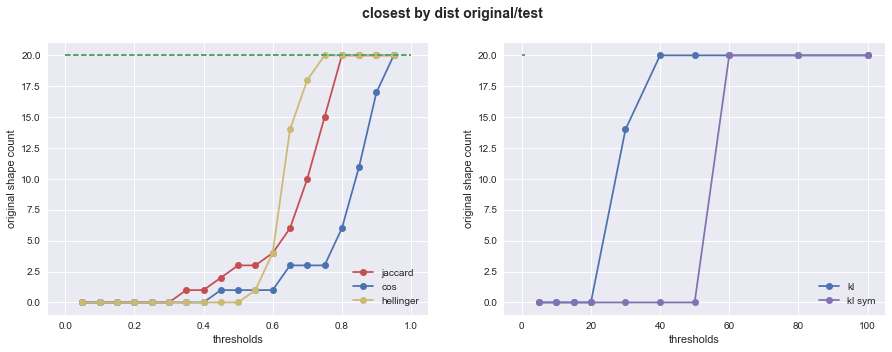

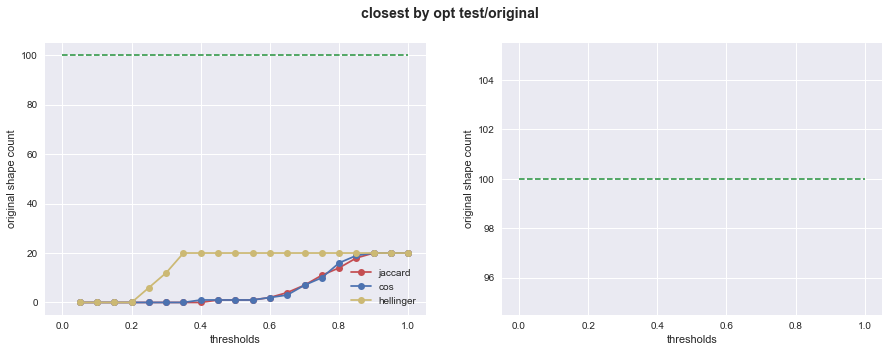

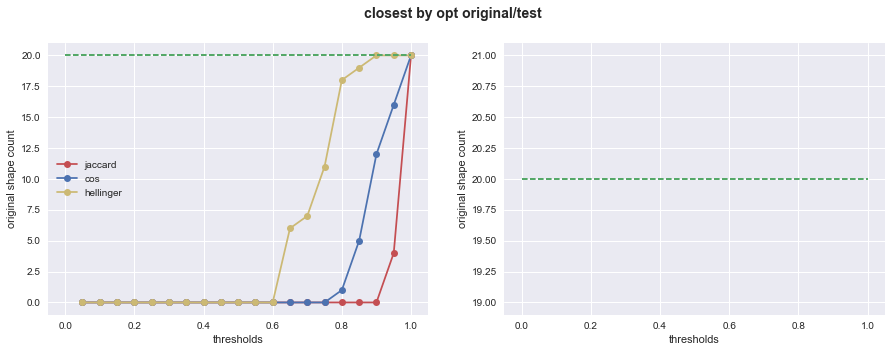

In [15]:
def create_model_rch_20_5_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    return tmp_model

idx = 35
names_list[idx] = u'model_rch_20_5_ts'
models_list[idx] = create_model_rch_20_5_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20, 0.66
* **kernel size**: 24 vs 124, **purity**: .63 vs .71, **contrast** .78 vs .79, **$phi_{ij}$**:  5
* **closest by dist**: похож порог, но немного меньше
* **inter distances**:

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|   0  	|   5 	|  20  	|
|   closest by dist original/test  	|     	|   -  	|   -  	|  -  	|
| closest by opt res test/original 	|     	| h20(0.35)	|     	|     	|
| closest by opt res original/test 	|     	|     	|   0  	| 18   	|
* **Выводы**: не очень отличается по dist от с регуляризаторами. по opt даже лучше (порог на 0.5 меньше) - наверное, из-за более общных тем
* **TODO**: 

## decorrelator + topic selection

name = create_model_rch_20_1_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_20_1_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_20_1_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.90
|phi_ij == 0| / n_topics       2126.43  2004.70
|phi_ij > 0.2| / n_topics         0.23     0.05
|phi_ij > 0.1| / n_topics         0.89     0.60
|phi_ij > 0.01| / n_topics       27.16    21.65
|phi_ij > 0.05| / n_topics        2.63     2.15
|phi_ij > 0.001| / n_topics      80.26   141.40
topic_kernel_average_size        23.68   112.05
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_2 not optimized
Column topic_6 not optimized
Column topic_7 not optimized
Column topic_11 not optimized
Column topic_12 not optimized
Column topic_17 not optimized
Column topic_19 not optimized
Dist fn = <functi

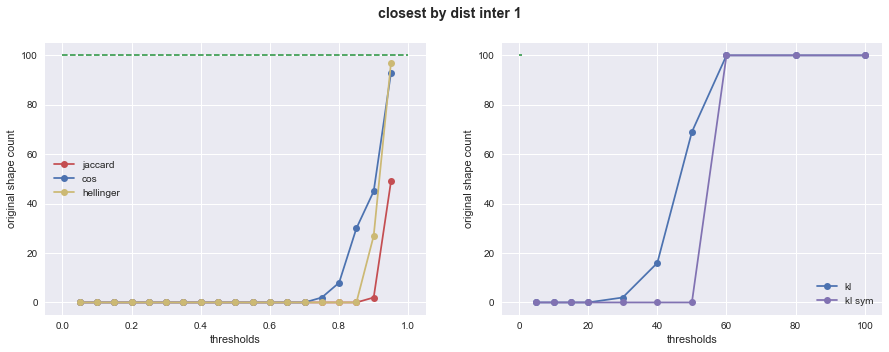

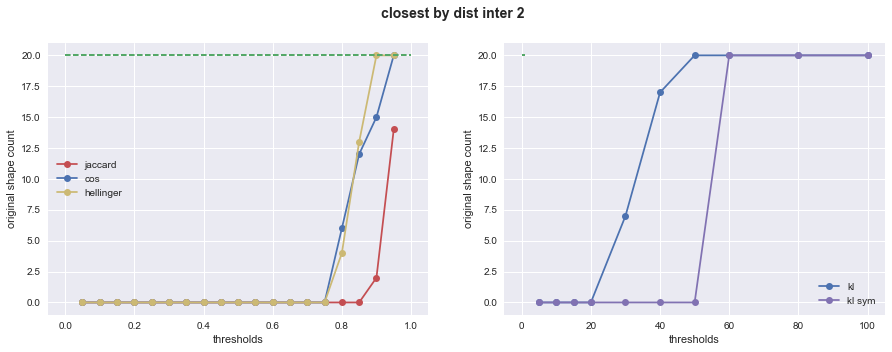

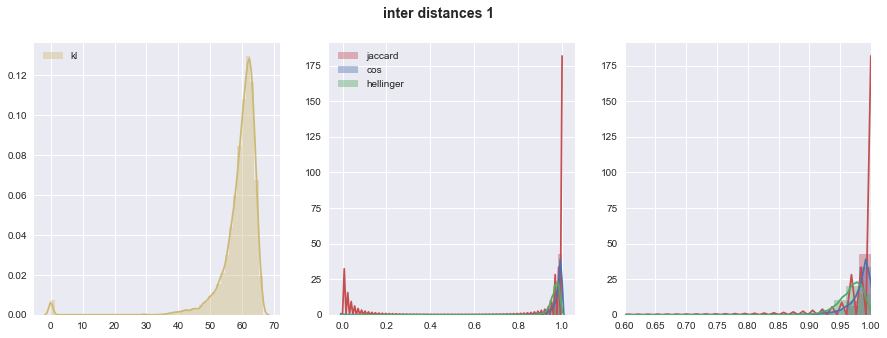

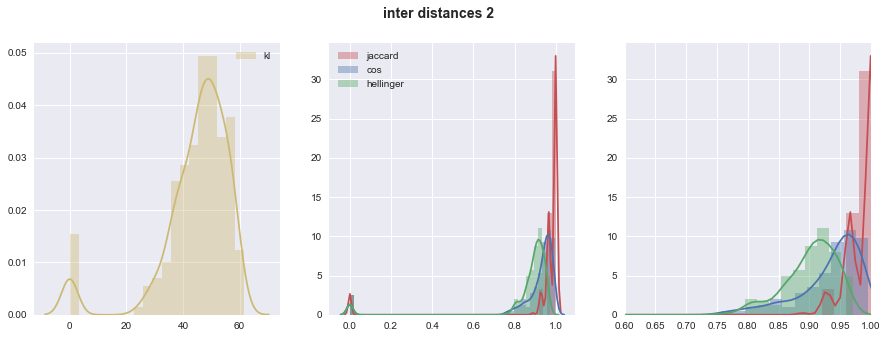

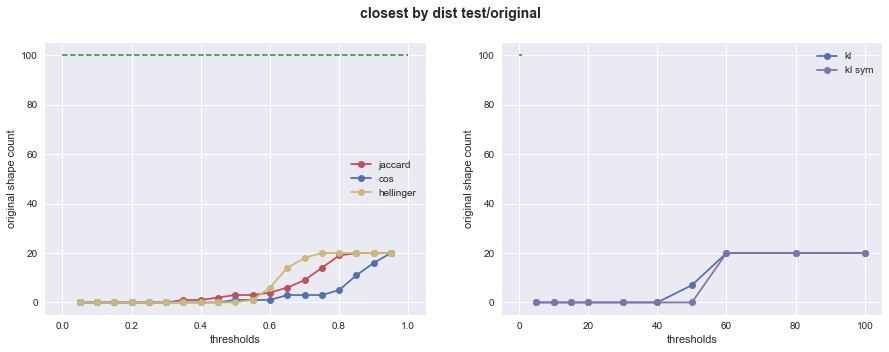

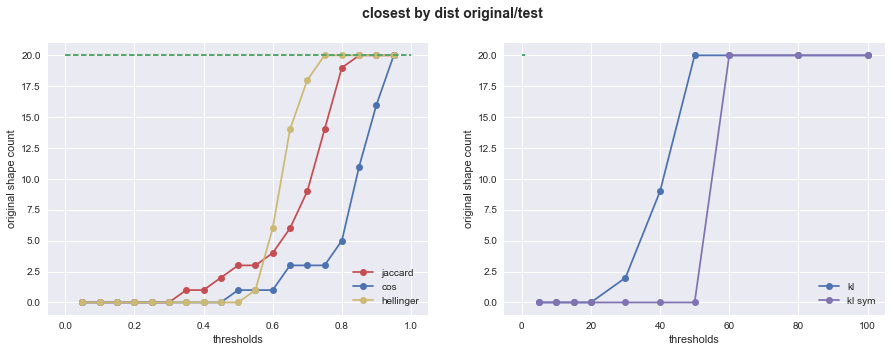

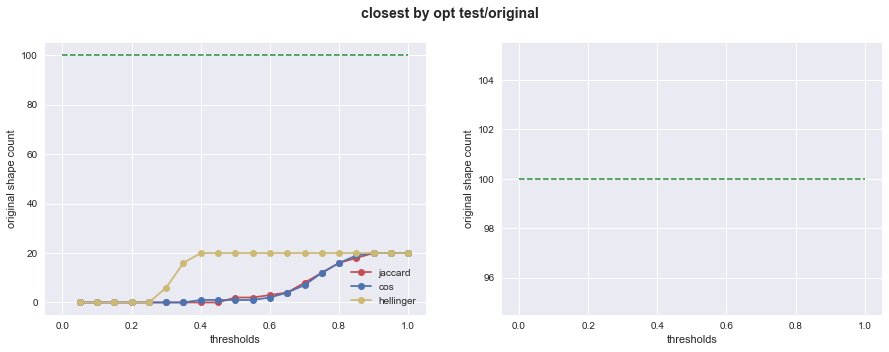

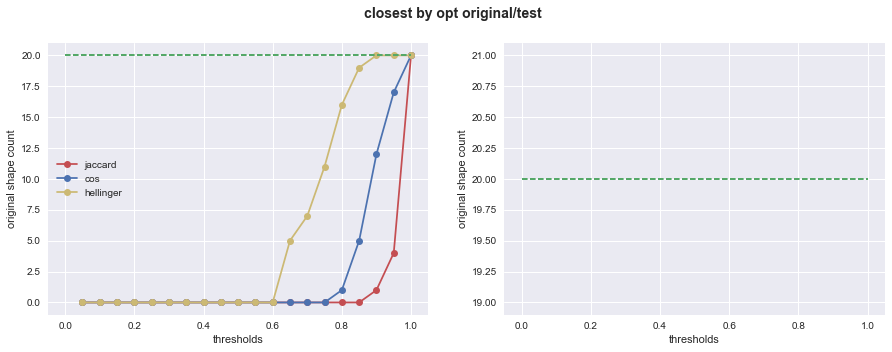

In [16]:
def create_model_rch_20_1_decor_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_20_1_decor_ts'
models_list[idx] = create_model_rch_20_1_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20, 0.9
* **kernel size**: 24 vs 112, **purity**: .63 vs .71, **contrast** .78 vs .84, **$phi_{ij}$**: -+++-
* **closest by dist**: похожи
* **inter distances**: размазанее

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|     	|  < 5 	|  20  	|
|   closest by dist original/test  	|     	|     	|   -  	|   -  	|
| closest by opt res test/original 	|     	|  h20 	|     	|     	|
| closest by opt res original/test 	|     	|     	|   0  	|  16  	|
* **Выводы**: 
* **TODO**: 

Спарсе по -1,5 для сравнения с без топик селектиона

name = create_model_rch_20_2_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_20_2_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_20_2_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.91
|phi_ij == 0| / n_topics       2126.43  2009.30
|phi_ij > 0.2| / n_topics         0.23     0.05
|phi_ij > 0.1| / n_topics         0.89     0.60
|phi_ij > 0.01| / n_topics       27.16    21.60
|phi_ij > 0.05| / n_topics        2.63     2.15
|phi_ij > 0.001| / n_topics      80.26   141.30
topic_kernel_average_size        23.68   112.25
topic_kernel_average_purity       0.63     0.72
topic_kernel_average_contrast     0.78     0.84

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_2 not optimized
Column topic_9 not optimized
Column topic_12 not optimized
Column topic_15 not optimized
Dist fn = <function hellinger_dist at 0x000000000BF09AC8>, Processed th = 1.0

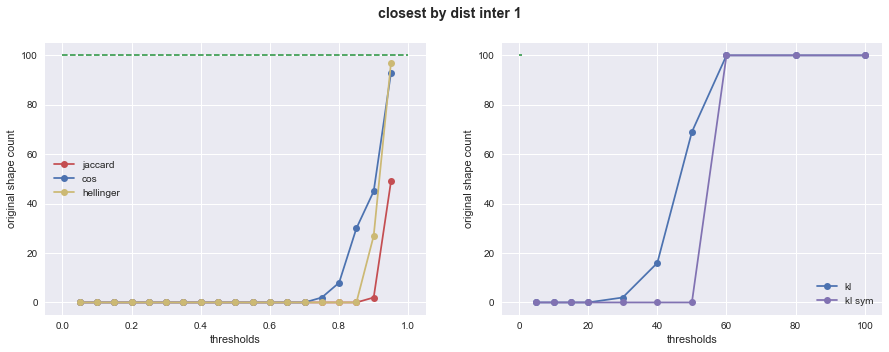

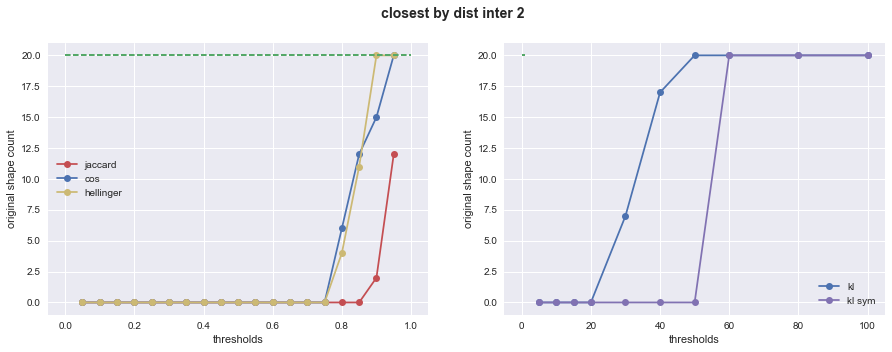

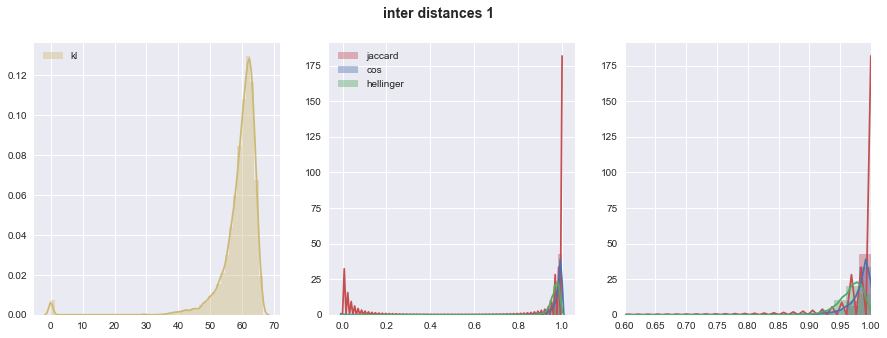

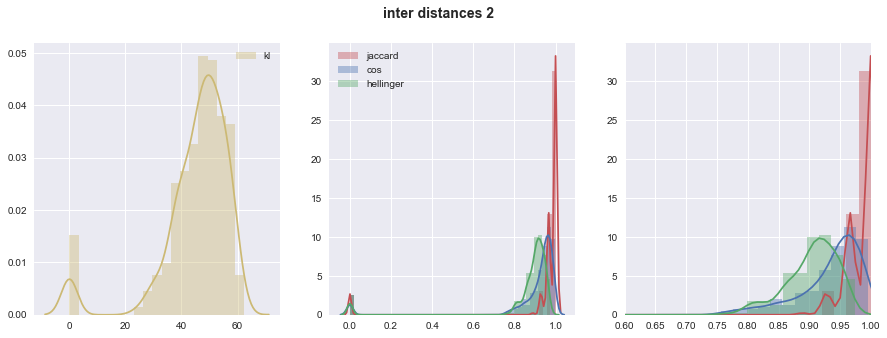

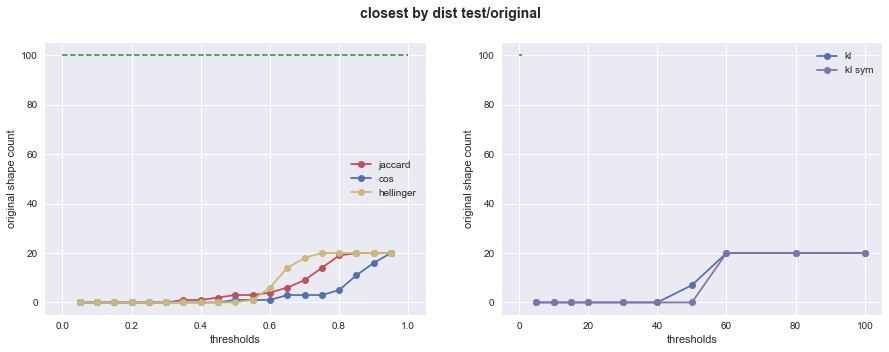

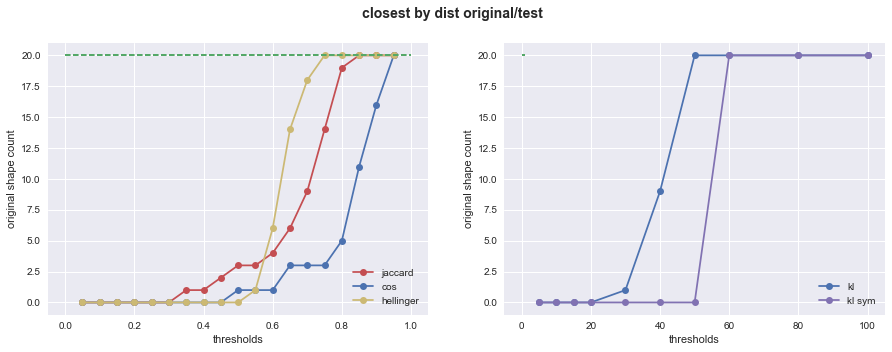

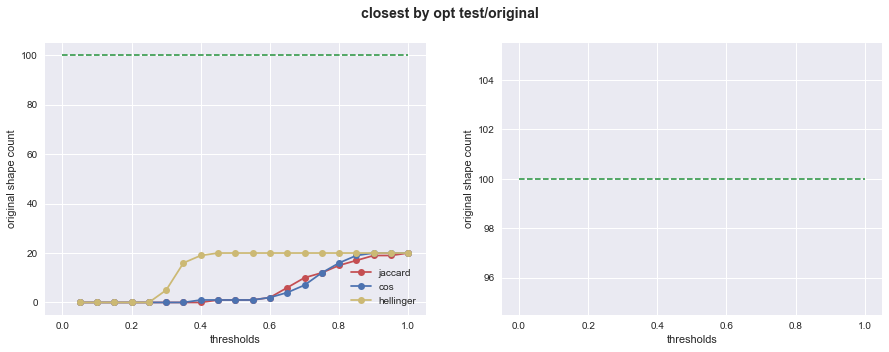

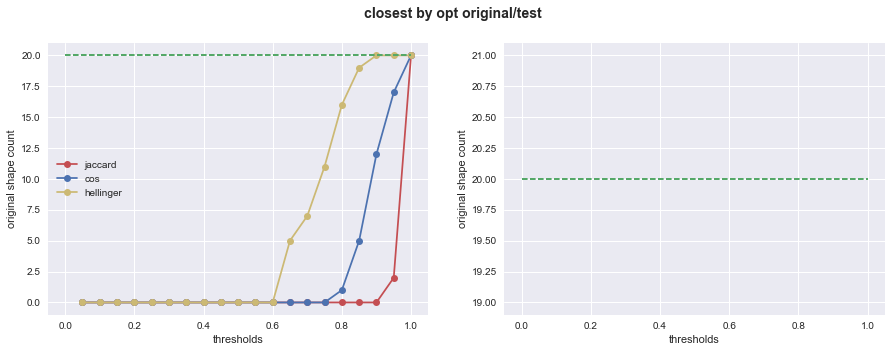

In [17]:
def create_model_rch_20_2_decor_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 42
names_list[idx] = u'create_model_rch_20_2_decor_ts'
models_list[idx] = create_model_rch_20_2_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 20 -> 20, 0.91
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: -+++- 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|   -  	|  -   	|  -   	|
|   closest by dist original/test  	|     	|     	|     	|     	|
| closest by opt res test/original 	|     	|     	|     	|     	|
| closest by opt res original/test 	|     	|     	|     	|     	|
* **Выводы**: вообще не отличается от без topic selection
* **TODO**: 

увеличим топик селекьтон коэф


name = create_model_rch_20_3_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_20_3_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

name = create_model_rch_20_3_decor_ts_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.9
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u't

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.90
|phi_ij == 0| / n_topics       2126.43  1996.05
|phi_ij > 0.2| / n_topics         0.23     0.05
|phi_ij > 0.1| / n_topics         0.89     0.60
|phi_ij > 0.01| / n_topics       27.16    21.30
|phi_ij > 0.05| / n_topics        2.63     2.15
|phi_ij > 0.001| / n_topics      80.26   141.75
topic_kernel_average_size        23.68   116.05
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.83

Dist fn = <function kl_sym_dist at 0x000000000BF09908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Processing <function jaccard_dist at 0x000000000BF09978>
Processing <function cos_dist at 0x000000000BF09A58>
Processing <function hellinger_dist at 0x000000000BF09AC8>
Processing <function kl_dist at 0x000000000BF09898>
Processing <function kl_sym_dist at 0x000000000BF09908>
Dist fn = <function cos_dist at 0x000000000BF09A58>, Processed th = 1.0, original columns count = 20           Column topic_0 not optimized
Column topic_7 not optimized
Column topic_9 not optimized
Column topic_10 not optimized
Column topic_11 not optimized
Column topic_16 not optimized
Dist fn = <function hellinger_dist at 0x0000000

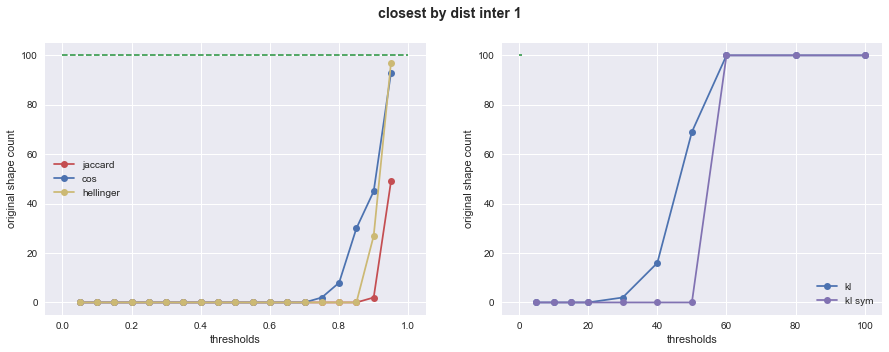

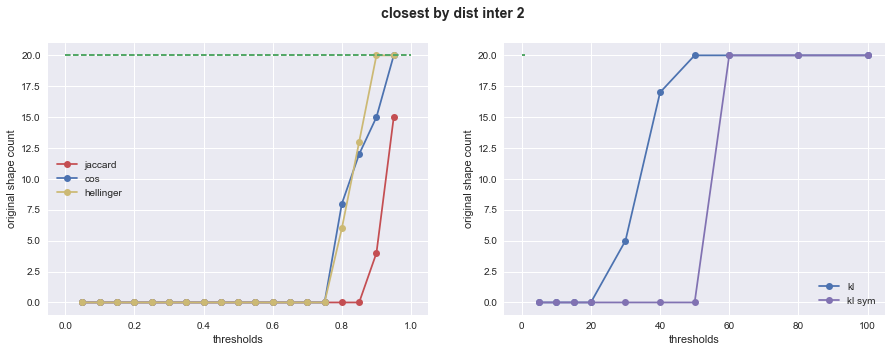

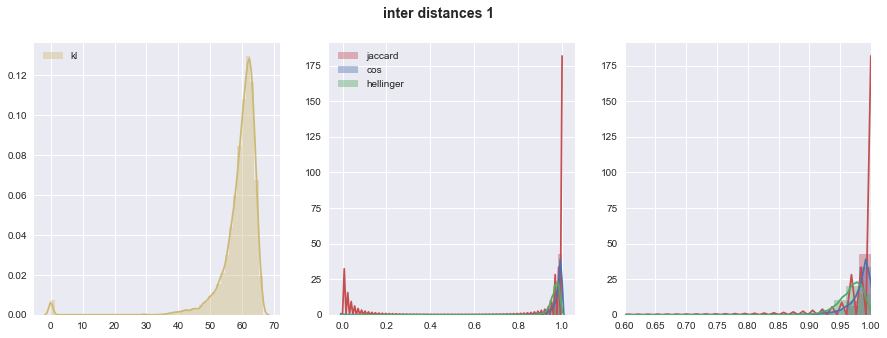

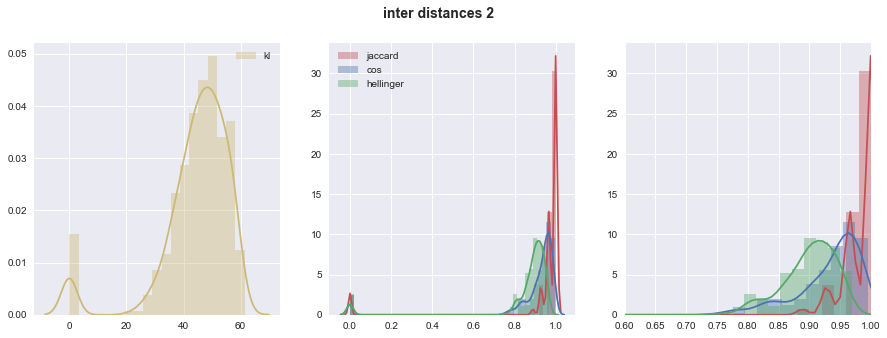

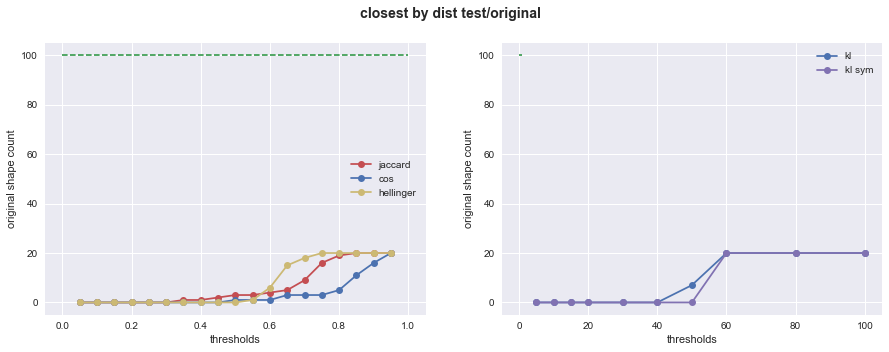

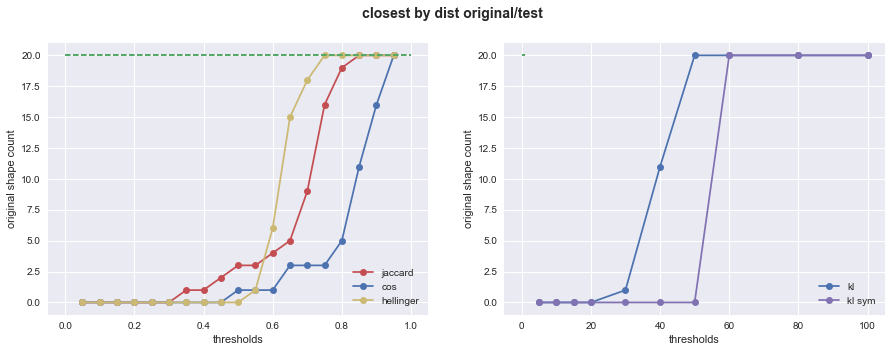

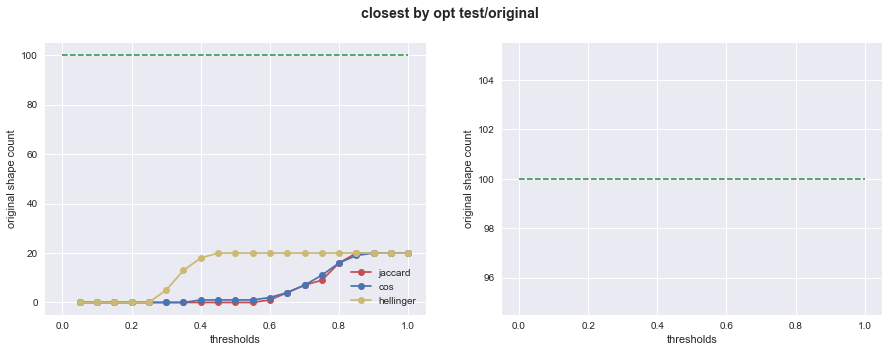

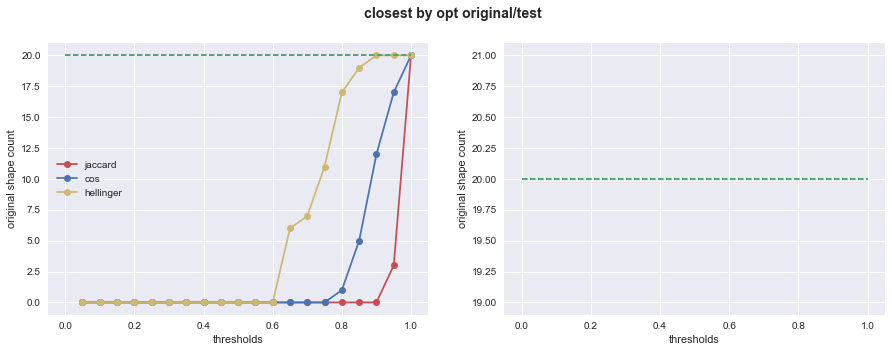

In [18]:
def create_model_rch_20_3_decor_ts(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.9
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_20_3_decor_ts'
models_list[idx] = create_model_rch_20_3_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 

the same
* **Выводы**: 
* **TODO**: 

In [19]:
save_pickle_file([different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix], 'result_20.p')
save_pickle_file([names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list], 'init_20.p')